# Inferring that the bike waitings time follow the exponential distribution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import dateutil.parser
import datetime
from scipy.optimize import curve_fit
from scipy.stats import expon
import math
from dateutil import tz

## Read data

In [3]:
df = pd.read_csv('../data/sorted_stations/Kampinmetroasema_sorted.csv', low_memory=False)

## Drop duplicates based on timestamp

In [4]:
df = df.drop_duplicates('ts').reset_index()

## Add some useful columns

In [5]:
# sort based on timestamp
df = df.sort_values('ts')
# the hour and minutes of the timestamp
df['hour_and_minutes'] = df['ts'].apply(lambda x: x[11:16])
# month of timestamp
df['month'] = df['ts'].apply(lambda x: x[5:7])
# the percentage of bikes
df['bikes_percent'] = df['bikes'] / df['total_slots']
df['minutes_from_midnight'] = df['ts'].apply(lambda x: int(x[11:13]) * 60 + int(x[14:16]))
# df['hour'] = df['hour_and_minutes'].apply(lambda x: x[:2])
df['date'] = df.ts.apply(lambda x: pd.to_datetime(x, utc=True).astimezone(tz.tzlocal()))
df['hour'] = df.date.apply(lambda x: x.hour)
df['weekday'] = df['date'].apply(lambda x: x.weekday())
df['weekend'] = df['weekday'].apply(lambda x: x > 4)
df.head()

index                   ts        lat        lon  operative  sid  \
0      0  2016-04-29T12:45:01  60.168644  24.930435          1  A30   
1      1  2016-04-29T12:46:01  60.168644  24.930435          1  A30   
2      2  2016-04-29T12:48:01  60.168644  24.930435          1  A30   
3      3  2016-05-01T08:20:01  60.168644  24.930435          1  A30   
4      4  2016-05-01T08:21:01  60.168644  24.930435          1  A30   

                name  bikes  total_slots hour_and_minutes month  \
0  Kampin metroasema      0           28            12:45    04   
1  Kampin metroasema      0           28            12:46    04   
2  Kampin metroasema      0           28            12:48    04   
3  Kampin metroasema      0           28            08:20    05   
4  Kampin metroasema      0           28            08:21    05   

   bikes_percent  minutes_from_midnight                      date  hour  \
0            0.0                    765 2016-04-29 15:45:01+03:00    15   
1            0.0                    766 2016-04-29 15:46:01+03:00    15   
2            0.0                    768 2016-04-29 15:48:01+03:00    15   
3            0.0                    500 2016-05-01 11:20:01+03:00    11   
4            0.0                    501 2016-05-01 11:21:01+03:00    11   

   weekday  weekend  
0        4    False  
1        4    False  
2        4    False  
3        6     True  
4        6     True

## Explore 

In [6]:
df.shape

(448054, 17)

In [7]:
df.describe()

index           lat           lon  operative          bikes  \
count  448054.000000  4.480540e+05  4.480540e+05   448054.0  448054.000000   
mean   224274.698300  6.016864e+01  2.493043e+01        1.0       4.798143   
std    129771.136239  1.407089e-10  1.234925e-11        0.0       4.918728   
min         0.000000  6.016864e+01  2.493043e+01        1.0       0.000000   
25%    112013.250000  6.016864e+01  2.493043e+01        1.0       1.000000   
50%    224026.500000  6.016864e+01  2.493043e+01        1.0       3.000000   
75%    336039.750000  6.016864e+01  2.493043e+01        1.0       7.000000   
max    462966.000000  6.016864e+01  2.493043e+01        1.0      33.000000   

         total_slots  bikes_percent  minutes_from_midnight           hour  \
count  448054.000000  448054.000000          448054.000000  448054.000000   
mean       29.413651       0.167223             741.930807      12.436543   
std         2.355847       0.175419             379.892851       6.607230   
min         1.000000       0.000000               0.000000       0.000000   
25%        28.000000       0.035714             430.000000       7.000000   
50%        28.000000       0.107143             745.000000      13.000000   
75%        33.000000       0.250000            1058.000000      18.000000   
max        33.000000       1.178571            1439.000000      23.000000   

             weekday  
count  448054.000000  
mean        3.021613  
std         1.991776  
min         0.000000  
25%         1.000000  
50%         3.000000  
75%         5.000000  
max         6.000000

In [8]:
df.head(10)

index                   ts        lat        lon  operative  sid  \
0      0  2016-04-29T12:45:01  60.168644  24.930435          1  A30   
1      1  2016-04-29T12:46:01  60.168644  24.930435          1  A30   
2      2  2016-04-29T12:48:01  60.168644  24.930435          1  A30   
3      3  2016-05-01T08:20:01  60.168644  24.930435          1  A30   
4      4  2016-05-01T08:21:01  60.168644  24.930435          1  A30   
5      5  2016-05-02T06:31:01  60.168644  24.930435          1  A30   
6      6  2016-05-02T06:32:01  60.168644  24.930435          1  A30   
7      7  2016-05-02T06:33:01  60.168644  24.930435          1  A30   
8      8  2016-05-02T06:36:01  60.168644  24.930435          1  A30   
9      9  2016-05-02T06:42:01  60.168644  24.930435          1  A30   

                name  bikes  total_slots hour_and_minutes month  \
0  Kampin metroasema      0           28            12:45    04   
1  Kampin metroasema      0           28            12:46    04   
2  Kampin metroasema      0           28            12:48    04   
3  Kampin metroasema      0           28            08:20    05   
4  Kampin metroasema      0           28            08:21    05   
5  Kampin metroasema      0           28            06:31    05   
6  Kampin metroasema      0           28            06:32    05   
7  Kampin metroasema      0           28            06:33    05   
8  Kampin metroasema      0           28            06:36    05   
9  Kampin metroasema      0           28            06:42    05   

   bikes_percent  minutes_from_midnight                      date  hour  \
0            0.0                    765 2016-04-29 15:45:01+03:00    15   
1            0.0                    766 2016-04-29 15:46:01+03:00    15   
2            0.0                    768 2016-04-29 15:48:01+03:00    15   
3            0.0                    500 2016-05-01 11:20:01+03:00    11   
4            0.0                    501 2016-05-01 11:21:01+03:00    11   
5            0.0                    391 2016-05-02 09:31:01+03:00     9   
6            0.0                    392 2016-05-02 09:32:01+03:00     9   
7            0.0                    393 2016-05-02 09:33:01+03:00     9   
8            0.0                    396 2016-05-02 09:36:01+03:00     9   
9            0.0                    402 2016-05-02 09:42:01+03:00     9   

   weekday  weekend  
0        4    False  
1        4    False  
2        4    False  
3        6     True  
4        6     True  
5        0    False  
6        0    False  
7        0    False  
8        0    False  
9        0    False

In [9]:
by_hour = df.groupby('hour_and_minutes').mean()[0::60]
by_hour

index        lat        lon  operative     bikes  \
hour_and_minutes                                                             
00:00             255989.825641  60.168644  24.930435        1.0  2.174359   
01:00             261231.364130  60.168644  24.930435        1.0  2.097826   
02:00             270803.115385  60.168644  24.930435        1.0  1.666667   
03:00             254976.460177  60.168644  24.930435        1.0  2.243363   
04:00             228373.466667  60.168644  24.930435        1.0  3.086667   
05:00             223809.227129  60.168644  24.930435        1.0  5.400631   
06:00             220349.478134  60.168644  24.930435        1.0  5.618076   
07:00             215768.711864  60.168644  24.930435        1.0  5.742938   
08:00             216747.935754  60.168644  24.930435        1.0  6.569832   
09:00             216447.247911  60.168644  24.930435        1.0  6.832869   
10:00             217386.920680  60.168644  24.930435        1.0  6.504249   
11:00             217408.853933  60.168644  24.930435        1.0  6.511236   
12:00             214753.142061  60.168644  24.930435        1.0  6.289694   
13:00             213233.008264  60.168644  24.930435        1.0  6.063361   
14:00             212846.553719  60.168644  24.930435        1.0  5.685950   
15:00             213279.370166  60.168644  24.930435        1.0  5.450276   
16:00             214887.770538  60.168644  24.930435        1.0  5.087819   
17:00             215100.060000  60.168644  24.930435        1.0  4.671429   
18:00             215825.977011  60.168644  24.930435        1.0  4.640805   
19:00             218334.461538  60.168644  24.930435        1.0  3.955621   
20:00             223444.709375  60.168644  24.930435        1.0  3.303125   
21:00             230691.983819  60.168644  24.930435        1.0  2.873786   
22:00             236488.272727  60.168644  24.930435        1.0  2.818182   
23:00             239255.057851  60.168644  24.930435        1.0  2.483471   

                  total_slots  bikes_percent  minutes_from_midnight  \
hour_and_minutes                                                      
00:00               29.871795       0.075602                    0.0   
01:00               29.956522       0.072776                   60.0   
02:00               30.275641       0.057130                  120.0   
03:00               29.783186       0.076983                  180.0   
04:00               29.500000       0.107352                  240.0   
05:00               29.388013       0.186786                  300.0   
06:00               29.341108       0.195219                  360.0   
07:00               29.299435       0.199541                  420.0   
08:00               29.298883       0.228893                  480.0   
09:00               29.220056       0.237987                  540.0   
10:00               29.303116       0.226638                  600.0   
11:00               29.306180       0.227315                  660.0   
12:00               29.295265       0.219477                  720.0   
13:00               29.206612       0.211704                  780.0   
14:00               29.267218       0.199030                  840.0   
15:00               29.270718       0.190333                  900.0   
16:00               29.303116       0.177906                  960.0   
17:00               29.314286       0.163080                 1020.0   
18:00               29.321839       0.162415                 1080.0   
19:00               29.360947       0.138406                 1140.0   
20:00               29.437500       0.115246                 1200.0   
21:00               29.488673       0.100078                 1260.0   
22:00               29.685606       0.097616                 1320.0   
23:00               29.756198       0.086124                 1380.0   

                       hour   weekday   weekend  
hour_and_minutes                                 
00:00              2.994872  3.600000  0.446154  


Text(0.5,1,'Bikes percentage each hour')

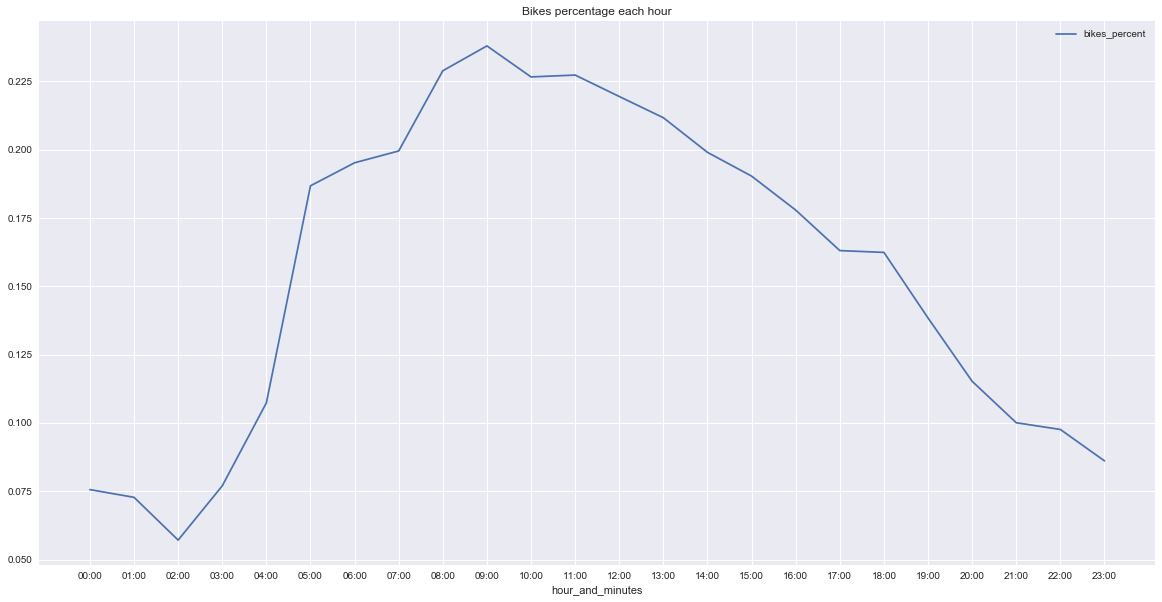

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
by_hour.plot(y='bikes_percent', ax=ax)
ax.set_xticks(range(len(by_hour.index)))
ax.set_xticklabels(by_hour.index)
plt.title('Bikes percentage each hour')

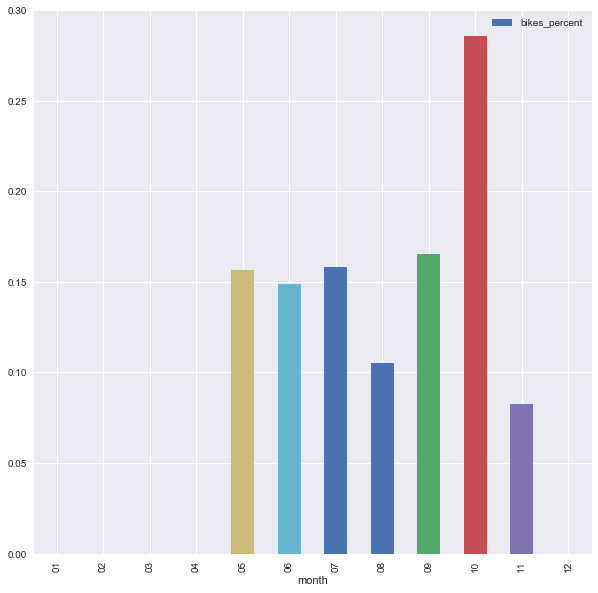

In [11]:
by_month = df.groupby('month').mean()
by_month.plot(y='bikes_percent', kind='bar', figsize=(10, 10))

In [12]:
# this is useful when using data from several stations
by_name = df.groupby('name').mean()
by_name

index        lat        lon  operative     bikes  \
name                                                                        
Kampin metroasema  224274.6983  60.168644  24.930435        1.0  4.798143   

                   total_slots  bikes_percent  minutes_from_midnight  \
name                                                                   
Kampin metroasema    29.413651       0.167223             741.930807   

                        hour   weekday   weekend  
name                                              
Kampin metroasema  12.436543  3.021613  0.288097

## Prepare for predictions

### Add column which states whether a bike was added at a given moment

In [13]:
df['bike_added'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] < x['bikes'] , axis=1)
df['bike_removed'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] > x['bikes'] , axis=1)
df.head(100)

index                   ts        lat        lon  operative  sid  \
0       0  2016-04-29T12:45:01  60.168644  24.930435          1  A30   
1       1  2016-04-29T12:46:01  60.168644  24.930435          1  A30   
2       2  2016-04-29T12:48:01  60.168644  24.930435          1  A30   
3       3  2016-05-01T08:20:01  60.168644  24.930435          1  A30   
4       4  2016-05-01T08:21:01  60.168644  24.930435          1  A30   
5       5  2016-05-02T06:31:01  60.168644  24.930435          1  A30   
6       6  2016-05-02T06:32:01  60.168644  24.930435          1  A30   
7       7  2016-05-02T06:33:01  60.168644  24.930435          1  A30   
8       8  2016-05-02T06:36:01  60.168644  24.930435          1  A30   
9       9  2016-05-02T06:42:01  60.168644  24.930435          1  A30   
10     10  2016-05-02T06:43:01  60.168644  24.930435          1  A30   
11     11  2016-05-02T06:45:01  60.168644  24.930435          1  A30   
12     12  2016-05-02T06:52:01  60.168644  24.930435          1  A30   
13     13  2016-05-02T06:53:01  60.168644  24.930435          1  A30   
14     14  2016-05-02T06:54:01  60.168644  24.930435          1  A30   
15     15  2016-05-02T06:59:01  60.168644  24.930435          1  A30   
16     16  2016-05-02T07:00:01  60.168644  24.930435          1  A30   
17     17  2016-05-02T07:01:01  60.168644  24.930435          1  A30   
18     18  2016-05-02T07:03:01  60.168644  24.930435          1  A30   
19     19  2016-05-02T07:07:01  60.168644  24.930435          1  A30   
20     20  2016-05-02T07:09:01  60.168644  24.930435          1  A30   
21     21  2016-05-02T07:10:01  60.168644  24.930435          1  A30   
22     22  2016-05-02T07:12:01  60.168644  24.930435          1  A30   
23     23  2016-05-02T07:13:01  60.168644  24.930435          1  A30   
24     24  2016-05-02T07:14:01  60.168644  24.930435          1  A30   
25     25  2016-05-02T07:15:01  60.168644  24.930435          1  A30   
26     26  2016-05-02T07:16:01  60.168644  24.930435          1  A30   
27     27  2016-05-02T07:17:01  60.168644  24.930435          1  A30   
28     28  2016-05-02T07:21:01  60.168644  24.930435          1  A30   
29     29  2016-05-02T07:22:01  60.168644  24.930435          1  A30   
..    ...                  ...        ...        ...        ...  ...   
70     70  2016-05-02T12:33:01  60.168644  24.930435          1  A30   
71     71  2016-05-02T12:34:01  60.168644  24.930435          1  A30   
72     72  2016-05-02T12:35:01  60.168644  24.930435          1  A30   
73     73  2016-05-02T12:36:01  60.168644  24.930435          1  A30   
74     74  2016-05-02T12:37:01  60.168644  24.930435          1  A30   
75     75  2016-05-02T12:38:01  60.168644  24.930435          1  A30   
76     76  2016-05-02T12:39:01  60.168644  24.930435          1  A30   
77     77  2016-05-02T12:40:01  60.168644  24.930435          1  A30   
78     78  2016-05-02T12:41:01  60.168644  24.930435          1  A30   
79     79  2016-05-02T12:42:01  60.168644  24.930435          1  A30   
80     80  2016-05-02T12:43:01  60.168644  24.930435          1  A30   
81     81  2016-05-02T12:44:01  60.168644  24.930435          1  A30   
82     82  2016-05-02T12:45:01  60.168644  24.930435          1  A30   
83     83  2016-05-02T12:46:01  60.168644  24.930435          1  A30   
84     84  2016-05-02T12:47:01  60.168644  24.930435          1  A30   
85     85  2016-05-02T12:48:01  60.168644  24.930435          1  A30   
86     86  2016-05-02T12:49:01  60.168644  24.930435          1  A30   
87     87  2016-05-02T12:50:01  60.168644  24.930435          1  A30   
88     88  2016-05-02T12:51:01  60.168644  24.930435          1  A30   
89     89  2016-05-02T12:52:01  60.168644  24.930435          1  A30   
90     90  2016-05-02T12:53:01  60.168644  24.930435          1  A30   
91     91  2016-05-02T12:54:01  60.168644  24.930435          1  A30   
92     92  2016-05-02T12:55:01  60.168644  24.930435          1  A30   
93     93  2016-05-02T12:56:01  60.168644  2

### Add max and running waiting time for next bike

In [14]:
# extract difference in minutes to a separate column
# on the moment that a bike was added, the waiting time is the time to next bike
i = 0
first_non_additive_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_added'] == False):
        i += 1
    if (i >= len(df)):
        break
    additive_row = df.iloc[i]
    time = additive_row['minutes_from_midnight']
    # add running time based on hour
    times_until_now = df.loc[first_non_additive_index:i-1, 'minutes_from_midnight']
    difference_1 = abs(time - times_until_now)
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'wait_for_new_bike'] = difference_1     
    first_non_additive_index = i
    i += 1
# if we can't know when the next bike will be added, fill with -1 for now
df = df.fillna(-1)
df.head(100)

index                   ts        lat        lon  operative  sid  \
0       0  2016-04-29T12:45:01  60.168644  24.930435          1  A30   
1       1  2016-04-29T12:46:01  60.168644  24.930435          1  A30   
2       2  2016-04-29T12:48:01  60.168644  24.930435          1  A30   
3       3  2016-05-01T08:20:01  60.168644  24.930435          1  A30   
4       4  2016-05-01T08:21:01  60.168644  24.930435          1  A30   
5       5  2016-05-02T06:31:01  60.168644  24.930435          1  A30   
6       6  2016-05-02T06:32:01  60.168644  24.930435          1  A30   
7       7  2016-05-02T06:33:01  60.168644  24.930435          1  A30   
8       8  2016-05-02T06:36:01  60.168644  24.930435          1  A30   
9       9  2016-05-02T06:42:01  60.168644  24.930435          1  A30   
10     10  2016-05-02T06:43:01  60.168644  24.930435          1  A30   
11     11  2016-05-02T06:45:01  60.168644  24.930435          1  A30   
12     12  2016-05-02T06:52:01  60.168644  24.930435          1  A30   
13     13  2016-05-02T06:53:01  60.168644  24.930435          1  A30   
14     14  2016-05-02T06:54:01  60.168644  24.930435          1  A30   
15     15  2016-05-02T06:59:01  60.168644  24.930435          1  A30   
16     16  2016-05-02T07:00:01  60.168644  24.930435          1  A30   
17     17  2016-05-02T07:01:01  60.168644  24.930435          1  A30   
18     18  2016-05-02T07:03:01  60.168644  24.930435          1  A30   
19     19  2016-05-02T07:07:01  60.168644  24.930435          1  A30   
20     20  2016-05-02T07:09:01  60.168644  24.930435          1  A30   
21     21  2016-05-02T07:10:01  60.168644  24.930435          1  A30   
22     22  2016-05-02T07:12:01  60.168644  24.930435          1  A30   
23     23  2016-05-02T07:13:01  60.168644  24.930435          1  A30   
24     24  2016-05-02T07:14:01  60.168644  24.930435          1  A30   
25     25  2016-05-02T07:15:01  60.168644  24.930435          1  A30   
26     26  2016-05-02T07:16:01  60.168644  24.930435          1  A30   
27     27  2016-05-02T07:17:01  60.168644  24.930435          1  A30   
28     28  2016-05-02T07:21:01  60.168644  24.930435          1  A30   
29     29  2016-05-02T07:22:01  60.168644  24.930435          1  A30   
..    ...                  ...        ...        ...        ...  ...   
70     70  2016-05-02T12:33:01  60.168644  24.930435          1  A30   
71     71  2016-05-02T12:34:01  60.168644  24.930435          1  A30   
72     72  2016-05-02T12:35:01  60.168644  24.930435          1  A30   
73     73  2016-05-02T12:36:01  60.168644  24.930435          1  A30   
74     74  2016-05-02T12:37:01  60.168644  24.930435          1  A30   
75     75  2016-05-02T12:38:01  60.168644  24.930435          1  A30   
76     76  2016-05-02T12:39:01  60.168644  24.930435          1  A30   
77     77  2016-05-02T12:40:01  60.168644  24.930435          1  A30   
78     78  2016-05-02T12:41:01  60.168644  24.930435          1  A30   
79     79  2016-05-02T12:42:01  60.168644  24.930435          1  A30   
80     80  2016-05-02T12:43:01  60.168644  24.930435          1  A30   
81     81  2016-05-02T12:44:01  60.168644  24.930435          1  A30   
82     82  2016-05-02T12:45:01  60.168644  24.930435          1  A30   
83     83  2016-05-02T12:46:01  60.168644  24.930435          1  A30   
84     84  2016-05-02T12:47:01  60.168644  24.930435          1  A30   
85     85  2016-05-02T12:48:01  60.168644  24.930435          1  A30   
86     86  2016-05-02T12:49:01  60.168644  24.930435          1  A30   
87     87  2016-05-02T12:50:01  60.168644  24.930435          1  A30   
88     88  2016-05-02T12:51:01  60.168644  24.930435          1  A30   
89     89  2016-05-02T12:52:01  60.168644  24.930435          1  A30   
90     90  2016-05-02T12:53:01  60.168644  24.930435          1  A30   
91     91  2016-05-02T12:54:01  60.168644  24.930435          1  A30   
92     92  2016-05-02T12:55:01  60.168644  24.930435          1  A30   
93     93  2016-05-02T12:56:01  60.168644  2

In [15]:
df.describe()

index           lat           lon  operative          bikes  \
count  448054.000000  4.480540e+05  4.480540e+05   448054.0  448054.000000   
mean   224274.698300  6.016864e+01  2.493043e+01        1.0       4.798143   
std    129771.136239  1.407089e-10  1.234925e-11        0.0       4.918728   
min         0.000000  6.016864e+01  2.493043e+01        1.0       0.000000   
25%    112013.250000  6.016864e+01  2.493043e+01        1.0       1.000000   
50%    224026.500000  6.016864e+01  2.493043e+01        1.0       3.000000   
75%    336039.750000  6.016864e+01  2.493043e+01        1.0       7.000000   
max    462966.000000  6.016864e+01  2.493043e+01        1.0      33.000000   

         total_slots  bikes_percent  minutes_from_midnight           hour  \
count  448054.000000  448054.000000          448054.000000  448054.000000   
mean       29.413651       0.167223             741.930807      12.436543   
std         2.355847       0.175419             379.892851       6.607230   
min         1.000000       0.000000               0.000000       0.000000   
25%        28.000000       0.035714             430.000000       7.000000   
50%        28.000000       0.107143             745.000000      13.000000   
75%        33.000000       0.250000            1058.000000      18.000000   
max        33.000000       1.178571            1439.000000      23.000000   

             weekday  wait_for_new_bike  
count  448054.000000      448054.000000  
mean        3.021613          72.408636  
std         1.991776         243.503032  
min         0.000000          -1.000000  
25%         1.000000           4.000000  
50%         3.000000           9.000000  
75%         5.000000          25.000000  
max         6.000000        1439.000000

### Add time for next bike take

Predict how much time for the next bike to be taken: max waiting time is not useful here.

In [16]:
i = 0
first_non_removing_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_removed'] == False):
        i += 1
    if (i >= len(df)):
        break
    removing_row = df.iloc[i]
    time = removing_row['minutes_from_midnight']
    times_until_now = df.loc[first_non_removing_index:i-1, 'minutes_from_midnight']
    difference = abs(time - times_until_now)
    df.loc[first_non_removing_index:(i-1 if i > 0 else 0), 'wait_for_bike_taken'] = difference 
    first_non_removing_index = i
    i += 1
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

index                   ts        lat        lon  operative  sid  \
0       0  2016-04-29T12:45:01  60.168644  24.930435          1  A30   
1       1  2016-04-29T12:46:01  60.168644  24.930435          1  A30   
2       2  2016-04-29T12:48:01  60.168644  24.930435          1  A30   
3       3  2016-05-01T08:20:01  60.168644  24.930435          1  A30   
4       4  2016-05-01T08:21:01  60.168644  24.930435          1  A30   
5       5  2016-05-02T06:31:01  60.168644  24.930435          1  A30   
6       6  2016-05-02T06:32:01  60.168644  24.930435          1  A30   
7       7  2016-05-02T06:33:01  60.168644  24.930435          1  A30   
8       8  2016-05-02T06:36:01  60.168644  24.930435          1  A30   
9       9  2016-05-02T06:42:01  60.168644  24.930435          1  A30   
10     10  2016-05-02T06:43:01  60.168644  24.930435          1  A30   
11     11  2016-05-02T06:45:01  60.168644  24.930435          1  A30   
12     12  2016-05-02T06:52:01  60.168644  24.930435          1  A30   
13     13  2016-05-02T06:53:01  60.168644  24.930435          1  A30   
14     14  2016-05-02T06:54:01  60.168644  24.930435          1  A30   
15     15  2016-05-02T06:59:01  60.168644  24.930435          1  A30   
16     16  2016-05-02T07:00:01  60.168644  24.930435          1  A30   
17     17  2016-05-02T07:01:01  60.168644  24.930435          1  A30   
18     18  2016-05-02T07:03:01  60.168644  24.930435          1  A30   
19     19  2016-05-02T07:07:01  60.168644  24.930435          1  A30   
20     20  2016-05-02T07:09:01  60.168644  24.930435          1  A30   
21     21  2016-05-02T07:10:01  60.168644  24.930435          1  A30   
22     22  2016-05-02T07:12:01  60.168644  24.930435          1  A30   
23     23  2016-05-02T07:13:01  60.168644  24.930435          1  A30   
24     24  2016-05-02T07:14:01  60.168644  24.930435          1  A30   
25     25  2016-05-02T07:15:01  60.168644  24.930435          1  A30   
26     26  2016-05-02T07:16:01  60.168644  24.930435          1  A30   
27     27  2016-05-02T07:17:01  60.168644  24.930435          1  A30   
28     28  2016-05-02T07:21:01  60.168644  24.930435          1  A30   
29     29  2016-05-02T07:22:01  60.168644  24.930435          1  A30   
30     30  2016-05-02T07:25:01  60.168644  24.930435          1  A30   
31     31  2016-05-02T07:26:01  60.168644  24.930435          1  A30   
32     32  2016-05-02T07:27:01  60.168644  24.930435          1  A30   
33     33  2016-05-02T07:29:01  60.168644  24.930435          1  A30   
34     34  2016-05-02T07:30:01  60.168644  24.930435          1  A30   
35     35  2016-05-02T07:31:01  60.168644  24.930435          1  A30   
36     36  2016-05-02T07:32:01  60.168644  24.930435          1  A30   
37     37  2016-05-02T07:35:01  60.168644  24.930435          1  A30   
38     38  2016-05-02T07:37:01  60.168644  24.930435          1  A30   
39     39  2016-05-02T07:38:01  60.168644  24.930435          1  A30   
40     40  2016-05-02T07:45:01  60.168644  24.930435          1  A30   
41     41  2016-05-02T07:46:01  60.168644  24.930435          1  A30   
42     42  2016-05-02T07:47:01  60.168644  24.930435          1  A30   
43     43  2016-05-02T07:48:01  60.168644  24.930435          1  A30   
44     44  2016-05-02T07:56:01  60.168644  24.930435          1  A30   
45     45  2016-05-02T08:09:01  60.168644  24.930435          1  A30   
46     46  2016-05-02T08:20:01  60.168644  24.930435          1  A30   
47     47  2016-05-02T08:21:01  60.168644  24.930435          1  A30   
48     48  2016-05-02T08:37:01  60.168644  24.930435          1  A30   
49     49  2016-05-02T08:41:01  60.168644  24.930435          1  A30   

                 name  bikes  total_slots hour_and_minutes  \
0   Kampin metroasema      0           28            12:45   
1   Kampin metroasema      0           28            12:46   
2   Kampin metroasema      0           28            12:48   
3   Kampin metroasema      0           28            08:20   
4   Kampin metroasema

### Add weather data

In [17]:
weather = pd.read_csv('../data/weather_all.csv')
weather.head()

Year  m  d   Time Time zone  Cloud amount (1/8)  Pressure (msl) (hPa)  \
0  2016  5  1  00:00       UTC                 1.0                1027.1   
1  2016  5  1  01:00       UTC                 3.0                1027.2   
2  2016  5  1  02:00       UTC                 0.0                1027.3   
3  2016  5  1  03:00       UTC                 0.0                1027.4   
4  2016  5  1  04:00       UTC                 0.0                1027.6   

   Relative humidity (%)  Precipitation intensity (mm/h)  \
0                   85.0                             0.0   
1                   82.0                             0.0   
2                   82.0                             0.0   
3                   82.0                             0.0   
4                   78.0                             0.0   

   Air temperature (degC)  Dew-point temperature (degC)  \
0                     5.8                           3.5   
1                     6.2                           3.3   
2                     5.8                           2.9   
3                     5.7                           2.9   
4                     7.0                           3.3   

   Horizontal visibility (m)  Wind direction (deg)  Gust speed (m/s)  \
0                    50000.0                 276.0               4.1   
1                    50000.0                 280.0               4.4   
2                    50000.0                 279.0               4.3   
3                    47870.0                 259.0               3.0   
4                    45900.0                 277.0               3.0   

   Wind speed (m/s)  
0               3.7  
1               3.7  
2               3.9  
3               2.2  
4               2.0

In [18]:
# fill missing values with the last known value
weather = weather.fillna(method="pad")

In [19]:
weather['merge_timestamp'] = weather.apply(lambda x: '%s/%s/%s %s' % (x['Year'], x['m'], x['d'], x['Time']), axis=1)

In [20]:
df['merge_timestamp'] = df.apply(lambda x: '%s/%s/%s %s' % (x['date'].year, x['date'].month, x['date'].day, x['date'].strftime('%H:00')), axis=1)

In [21]:
df = pd.merge(df, weather, on='merge_timestamp')

In [22]:
df = df.drop(columns=['Year', 'm', 'd', 'Time', 'Time zone', 'merge_timestamp'])

In [23]:
df.columns.values

array(['index', 'ts', 'lat', 'lon', 'operative', 'sid', 'name', 'bikes',
       'total_slots', 'hour_and_minutes', 'month', 'bikes_percent',
       'minutes_from_midnight', 'date', 'hour', 'weekday', 'weekend',
       'bike_added', 'bike_removed', 'wait_for_new_bike',
       'wait_for_bike_taken', 'Cloud amount (1/8)',
       'Pressure (msl) (hPa)', 'Relative humidity (%)',
       'Precipitation intensity (mm/h)', 'Air temperature (degC)',
       'Dew-point temperature (degC)', 'Horizontal visibility (m)',
       'Wind direction (deg)', 'Gust speed (m/s)', 'Wind speed (m/s)'],
      dtype=object)

In [24]:
df.shape

(448051, 31)

In [25]:
df.head()

index                   ts        lat        lon  operative  sid  \
0      3  2016-05-01T08:20:01  60.168644  24.930435          1  A30   
1      4  2016-05-01T08:21:01  60.168644  24.930435          1  A30   
2      5  2016-05-02T06:31:01  60.168644  24.930435          1  A30   
3      6  2016-05-02T06:32:01  60.168644  24.930435          1  A30   
4      7  2016-05-02T06:33:01  60.168644  24.930435          1  A30   

                name  bikes  total_slots hour_and_minutes        ...         \
0  Kampin metroasema      0           28            08:20        ...          
1  Kampin metroasema      0           28            08:21        ...          
2  Kampin metroasema      0           28            06:31        ...          
3  Kampin metroasema      0           28            06:32        ...          
4  Kampin metroasema      0           28            06:33        ...          

  Cloud amount (1/8)  Pressure (msl) (hPa)  Relative humidity (%)  \
0                0.0                1027.2                   39.0   
1                0.0                1027.2                   39.0   
2                0.0                1025.7                   32.0   
3                0.0                1025.7                   32.0   
4                0.0                1025.7                   32.0   

  Precipitation intensity (mm/h)  Air temperature (degC)  \
0                            0.0                    15.1   
1                            0.0                    15.1   
2                            0.0                    15.4   
3                            0.0                    15.4   
4                            0.0                    15.4   

   Dew-point temperature (degC)  Horizontal visibility (m)  \
0                           1.4                    37690.0   
1                           1.4                    37690.0   
2                          -1.3                    30680.0   
3                          -1.3                    30680.0   
4                          -1.3                    30680.0   

   Wind direction (deg)  Gust speed (m/s)  Wind speed (m/s)  
0                 187.0               8.6               6.0  
1                 187.0               8.6               6.0  
2                 201.0               6.2               4.1  
3                 201.0               6.2               4.1  
4                 201.0               6.2               4.1  

[5 rows x 31 columns]

## Plot division of max waiting time for new bike

### Sorted by frequency

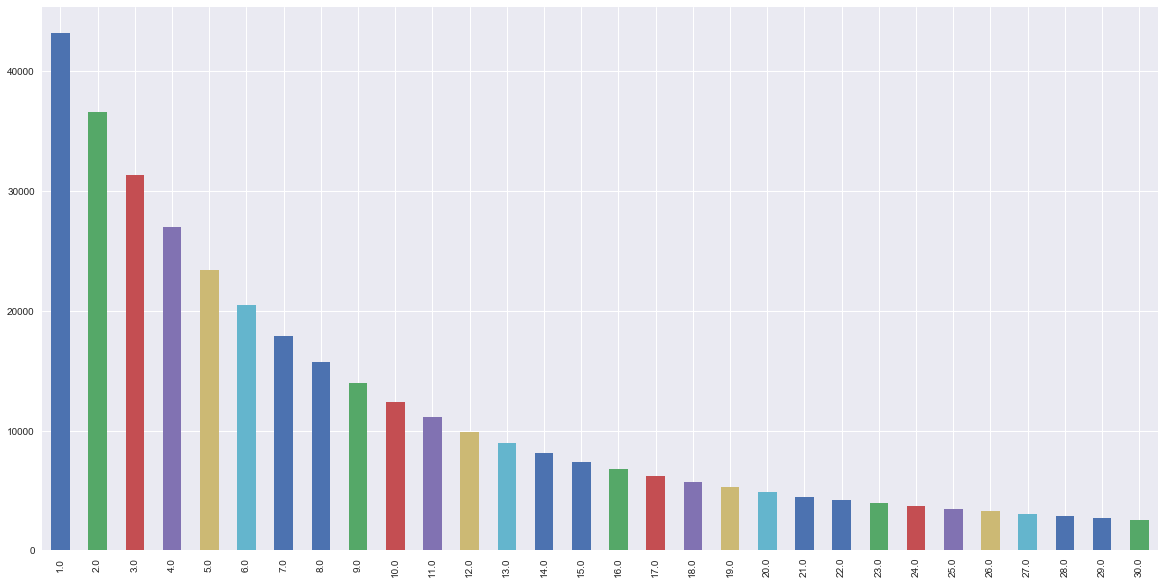

In [27]:
# sort by frequency
by_max_wait = df['wait_for_new_bike'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_max_wait.plot(kind='bar', figsize=(20, 10))

### Sorted by waiting time

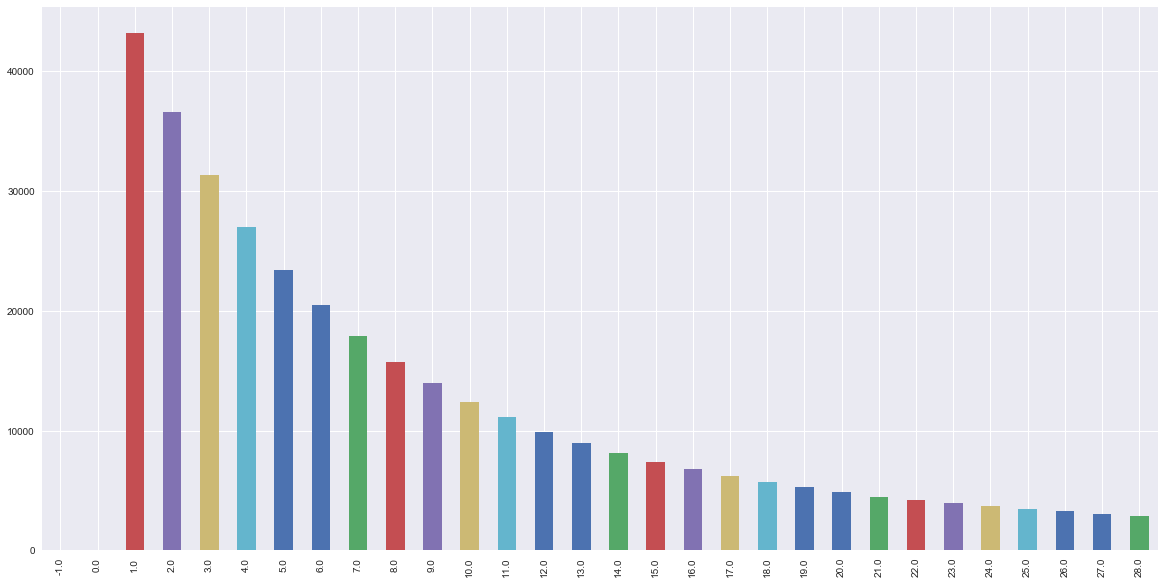

In [29]:
# sort by waiting time
by_max_wait_count = df['wait_for_new_bike'].value_counts()
by_max_wait_sorted = by_max_wait_count.sort_index().head(30)
by_max_wait_normalized = by_max_wait_sorted.index
by_max_wait_sorted.plot(kind='bar', figsize=(20, 10))

### Normalized waiting time

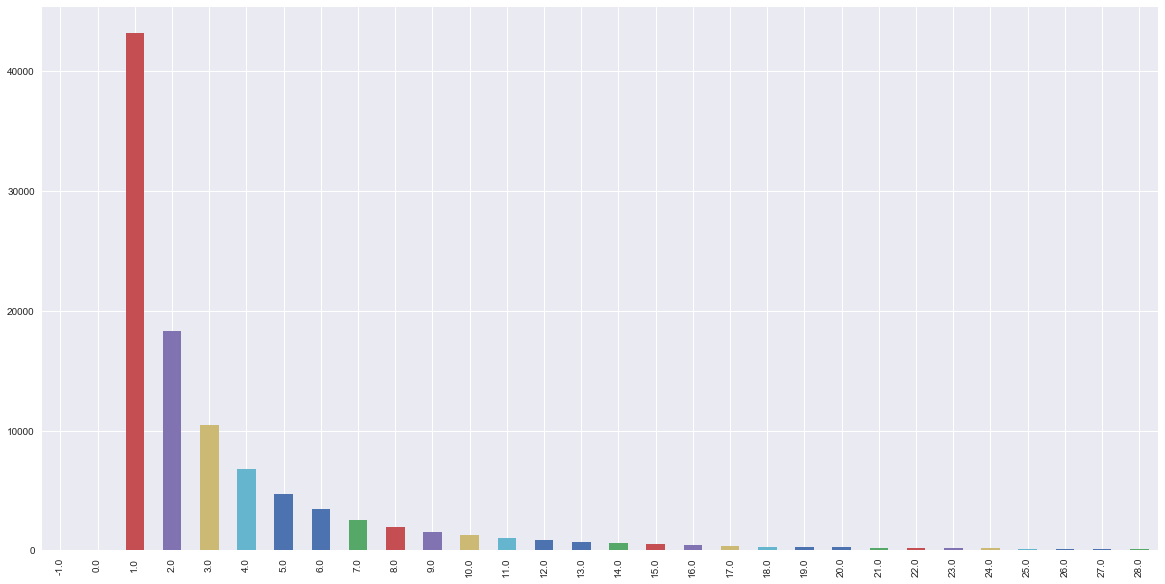

In [30]:
# normalize by dividing by key in order not to emphasize big values
by_max_wait_normalized = abs(by_max_wait_sorted / by_max_wait_sorted.index)
by_max_wait_normalized.plot(kind='bar', figsize=(20, 10))

## Plot distribution of wait for next taken bike

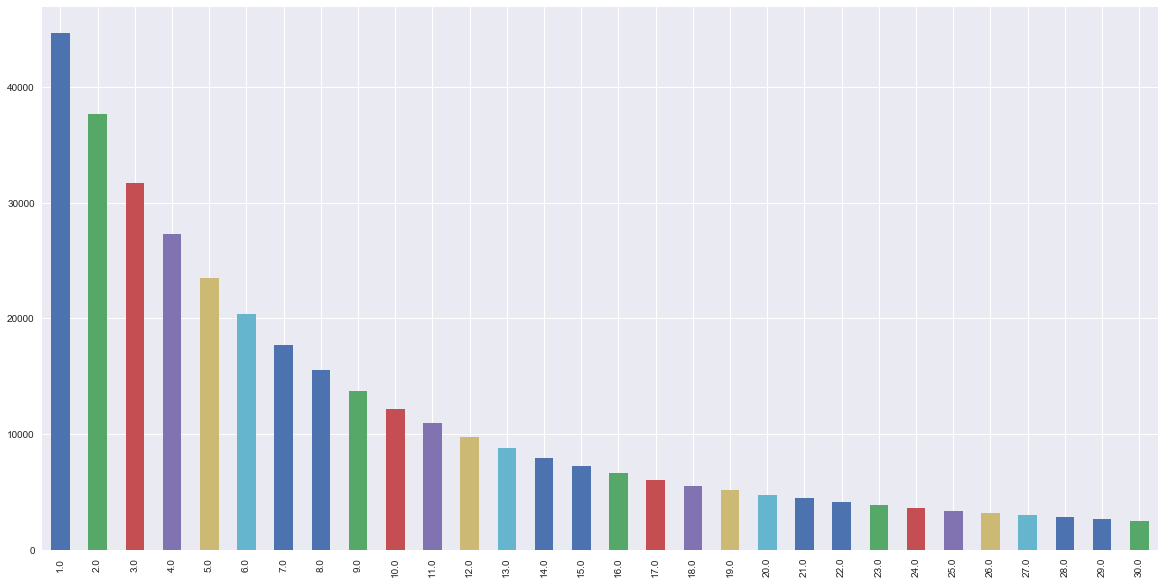

In [31]:
# sort by frequency
by_take_wait = df['wait_for_bike_taken'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_take_wait.plot(kind='bar', figsize=(20, 10))

# Both of the plots look a lot like the exponential curve

# Use exponential distribution as baseline and fit weather data to linear model

### Remove useless or codependent columns

In [34]:
max_wait_counts = df['wait_for_new_bike'].value_counts()
wait_counts = df['wait_for_bike_taken'].value_counts()

In [38]:
cleaned_df = df.drop(columns=['index', 'ts', 'sid', 'hour_and_minutes', 'name', 'bike_added', 'bike_removed', 'lat', 'lon', 'bikes', 'total_slots', 'minutes_from_midnight', 'date'])
# remove outliers = if theres less than 10 data points of a specific waiting time
filterable_max_waits = max_wait_counts[max_wait_counts < 10].index
filterable_waits = wait_counts[wait_counts < 10].index
cleaned_df = cleaned_df[~cleaned_df['wait_for_new_bike'].isin(filterable_max_waits)]
cleaned_df = cleaned_df[~cleaned_df['wait_for_bike_taken'].isin(filterable_waits)]
print('removed', len(df) - len(cleaned_df), 'rows')

removed 2494 rows


## Merge built distribution with other data

## Fit exponential distribution for each day and hour

In [39]:
def expfunc(x, l):
    return l * math.e ** (-l * x)
def get_estimate(scale):
    return expon.ppf(0.75, scale=1/scale)
def learn_parameter(waits):
    return curve_fit(expfunc, waits.keys(), waits.values, p0=0)

In [40]:
estimates = []
# somewhat "light rain"
rain_limit = 0.2
temp_limit = 20
weekdays = ['Monday', 'Tuesday', 'Wednesdy', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in range(7):
    for hour in range(24):
        curr_data = cleaned_df[(cleaned_df.weekday == weekday) & (cleaned_df.hour == hour)]
        waits = curr_data.wait_for_new_bike.value_counts(normalize=True).sort_index()
        # according to temperature
        cold = curr_data[curr_data['Air temperature (degC)'] < temp_limit]
        cold_waits = cold.wait_for_new_bike.value_counts(normalize=True).sort_index()
        warm = curr_data[curr_data['Air temperature (degC)'] >= temp_limit]
        warm_waits = warm.wait_for_new_bike.value_counts(normalize=True).sort_index()
        # according to amount of rain
        no_rain = curr_data[curr_data['Precipitation intensity (mm/h)'] <  rain_limit]
        with_rain = curr_data[curr_data['Precipitation intensity (mm/h)'] >=   rain_limit]
        no_rain_waits = no_rain.wait_for_new_bike.value_counts(normalize=True).sort_index()
        rain_waits = with_rain.wait_for_new_bike.value_counts(normalize=True).sort_index()
        if len(waits.values) == 0 or len(rain_waits.values) == 0 or len(warm.values) == 0:
            continue
        # fit exponential distribution to curve
        popt, _ = learn_parameter(waits)
        rain_popt, _ = learn_parameter(rain_waits)
        warm_popt, _ = learn_parameter(warm_waits)
        # get estimates
        all_estimate = get_estimate(popt[0])
        rain_estimate = get_estimate(rain_popt[0])
        warm_estimate = get_estimate(warm_popt[0])     
        estimate = get_estimate(popt[0])
        # build estimation dictionary
        estimates.append({
            'weekday': weekday, 
            'hour': hour, 
            'estimate': estimate, 
            'rain_estimate': rain_estimate, 
            'warm_estimate': warm_estimate, 
            'label': weekdays[weekday],
            'waits': waits,
            'no_rain_waits': no_rain_waits,
            'rain_waits': rain_waits,
            'cold_waits': cold_waits,
            'warm_waits': warm_waits
        })
len(estimates)

157

In [41]:
df['Precipitation intensity (mm/h)'].describe()

count    448051.000000
mean          0.077599
std           0.557577
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.700000
Name: Precipitation intensity (mm/h), dtype: float64

## Plot waiting times for each hour

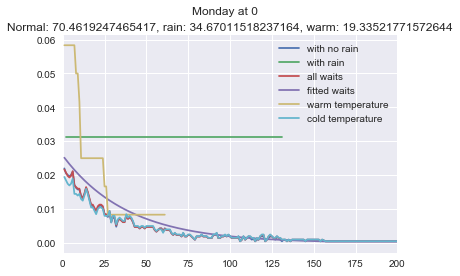

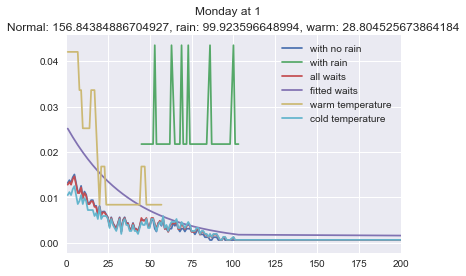

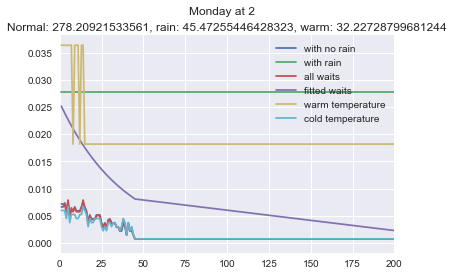

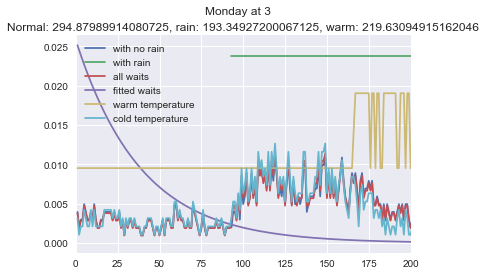

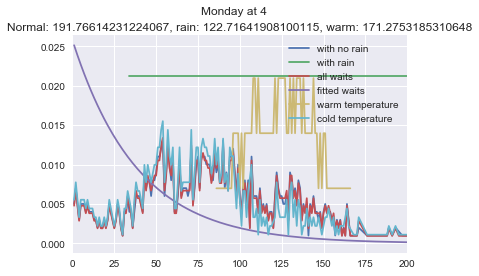

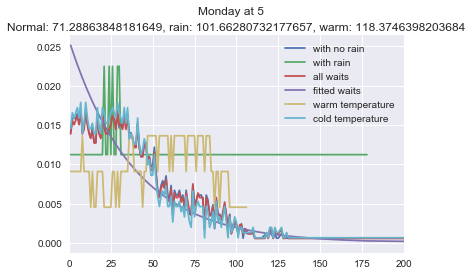

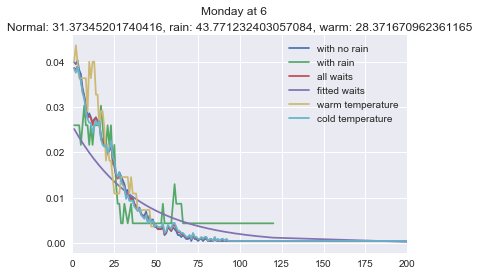

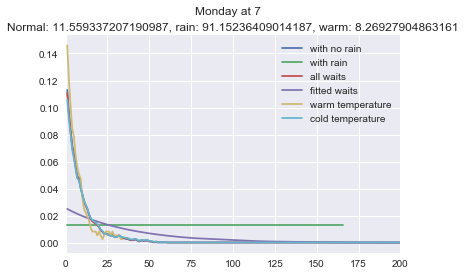

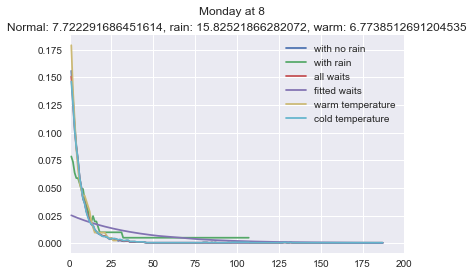

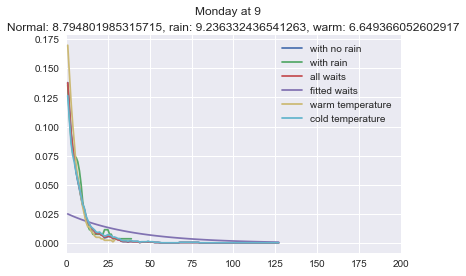

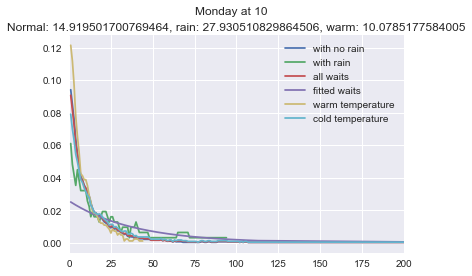

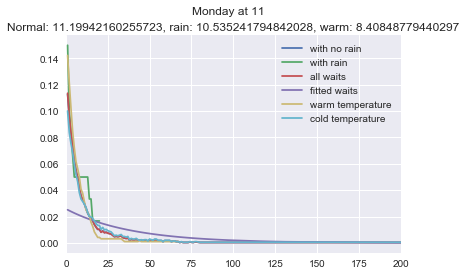

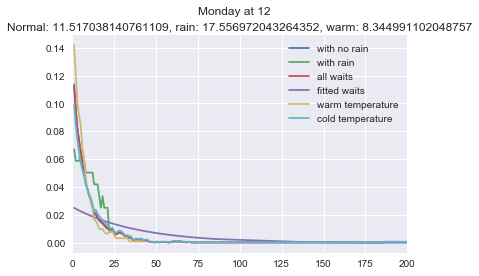

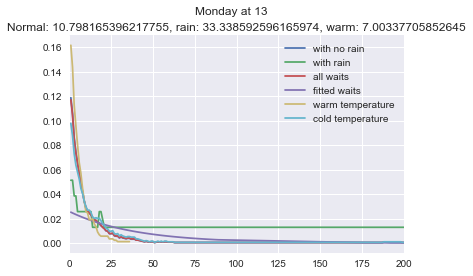

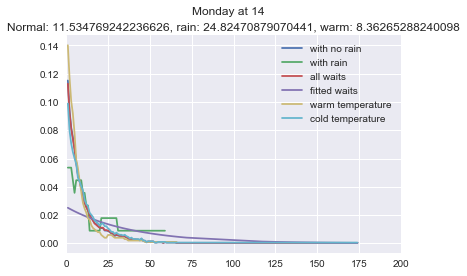

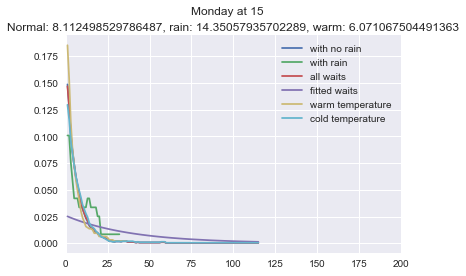

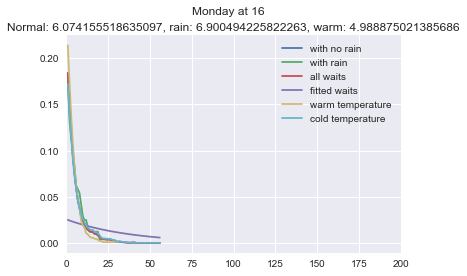

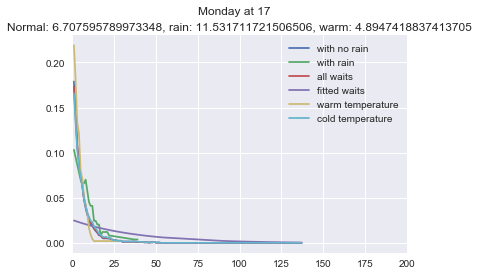

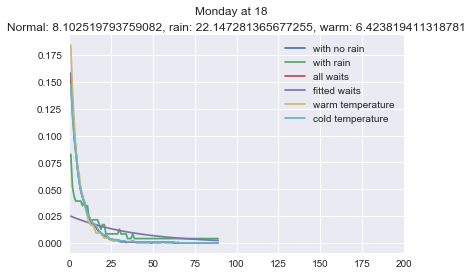

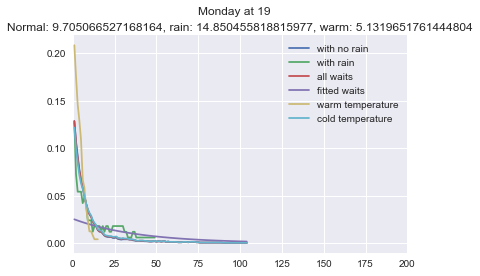

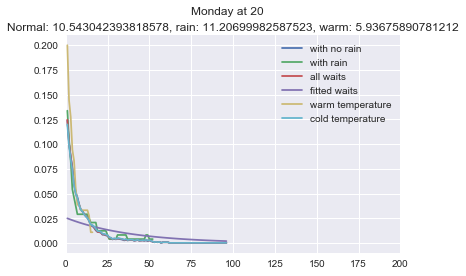

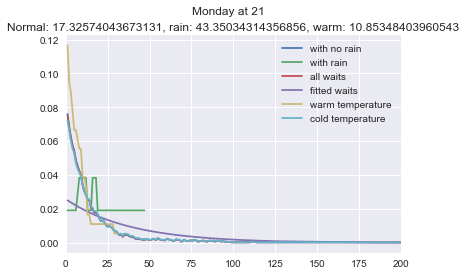

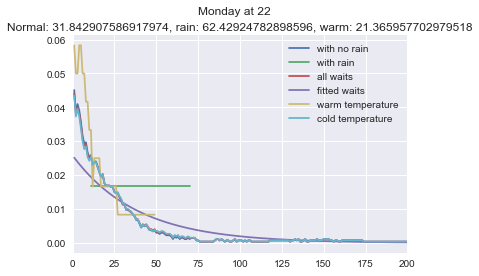

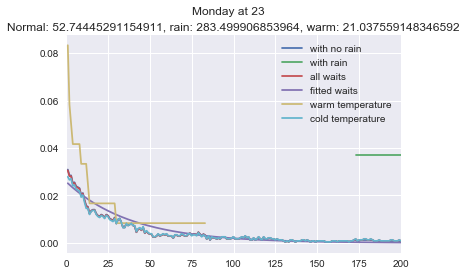

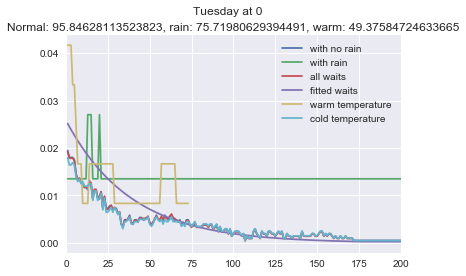

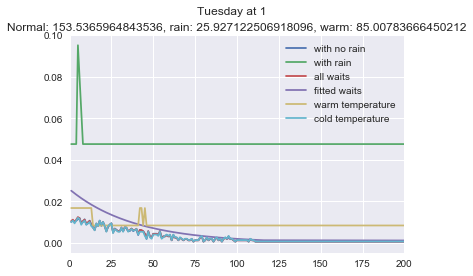

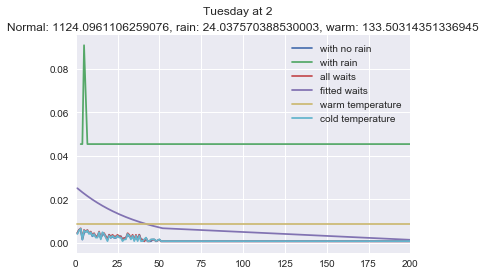

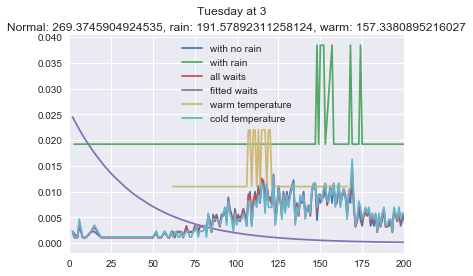

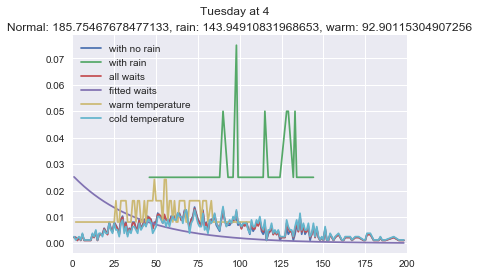

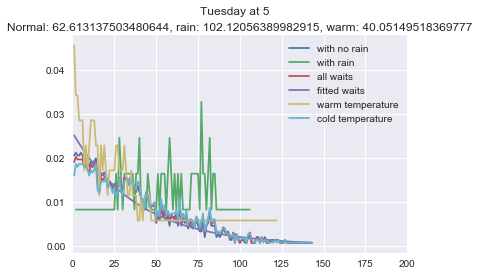

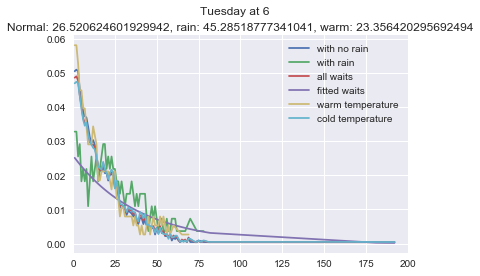

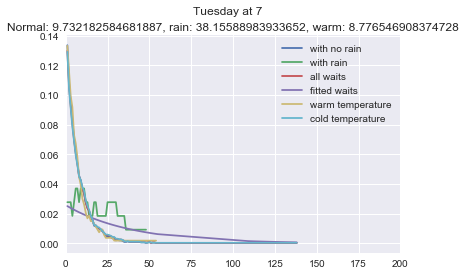

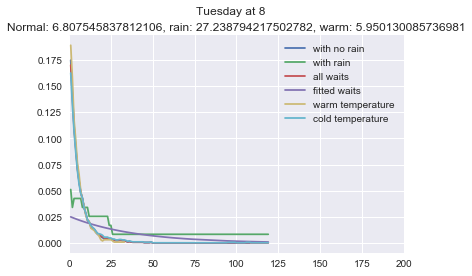

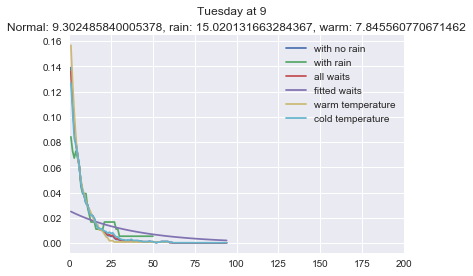

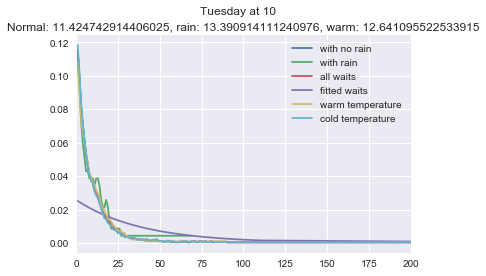

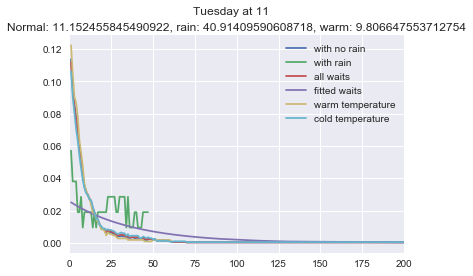

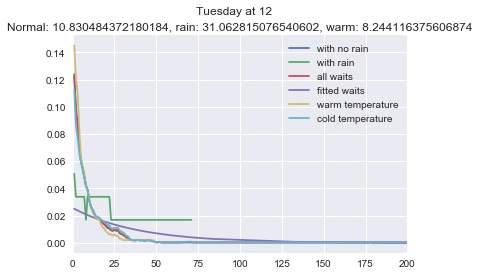

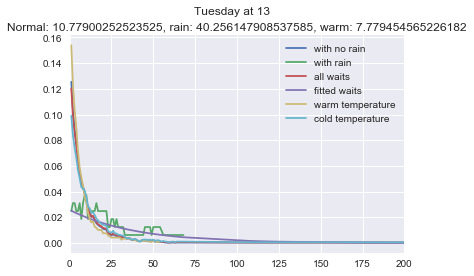

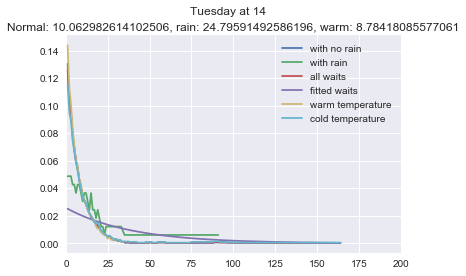

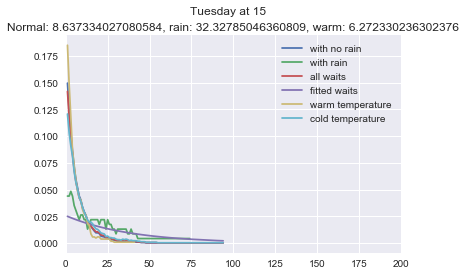

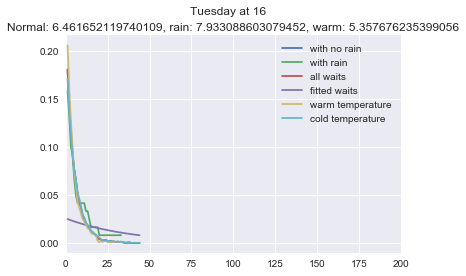

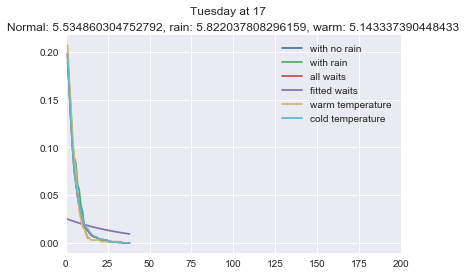

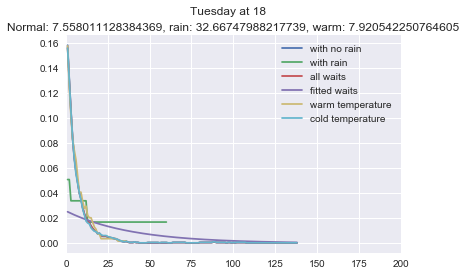

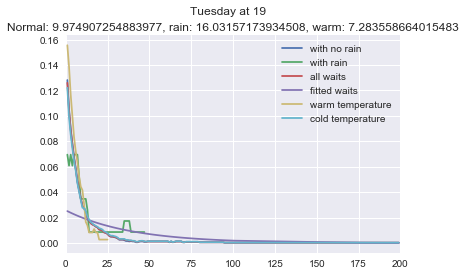

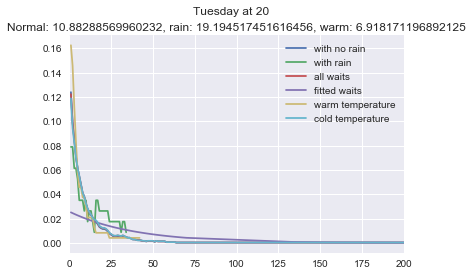

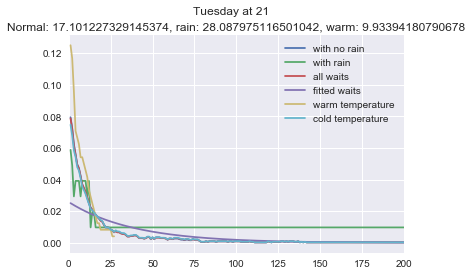

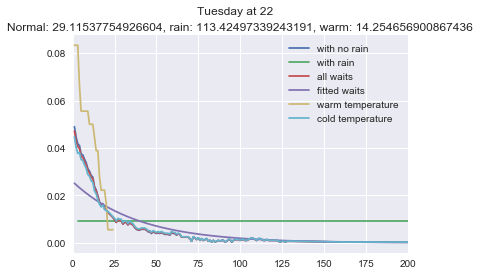

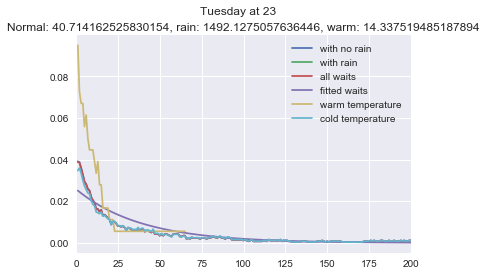

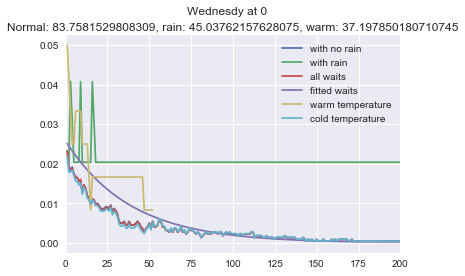

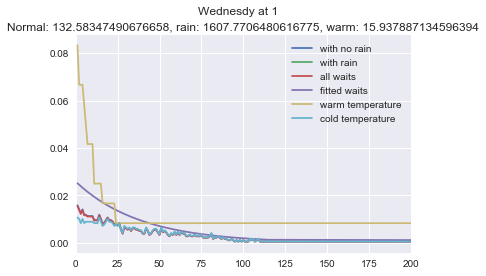

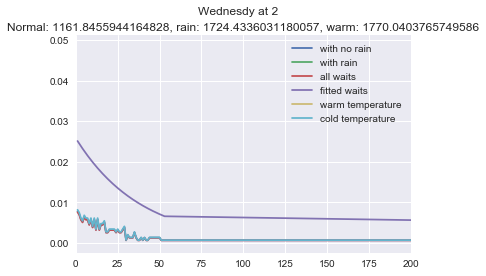

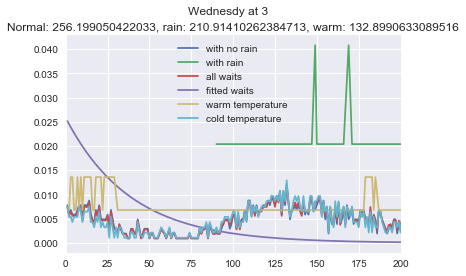

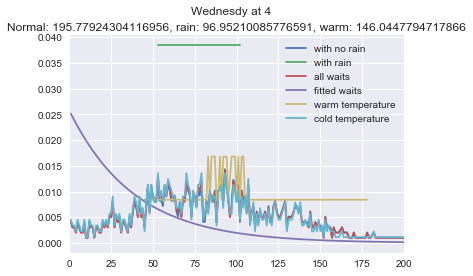

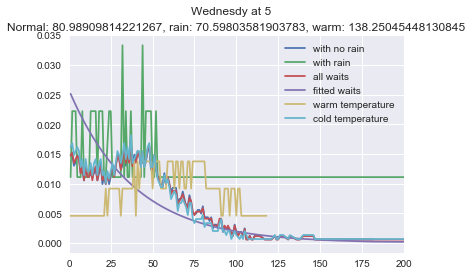

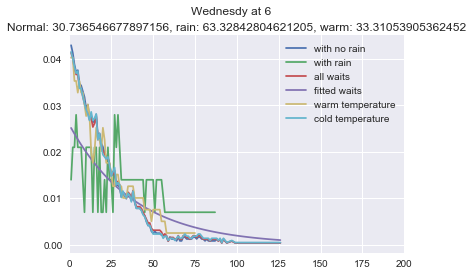

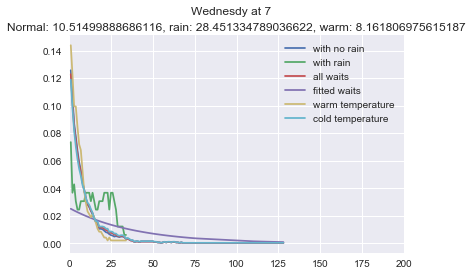

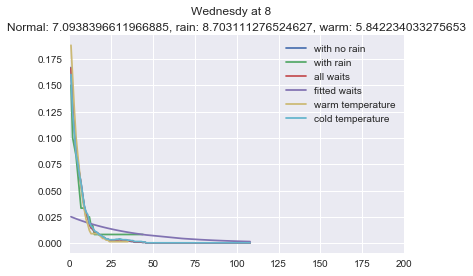

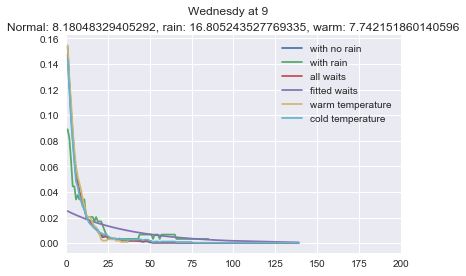

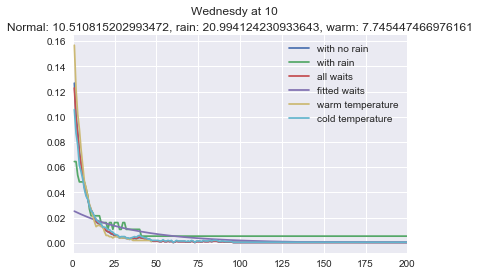

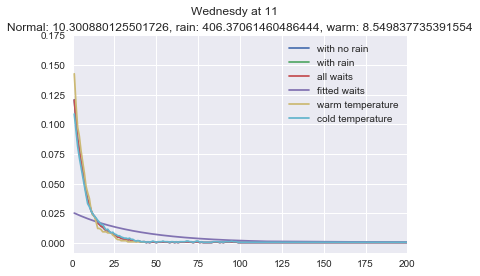

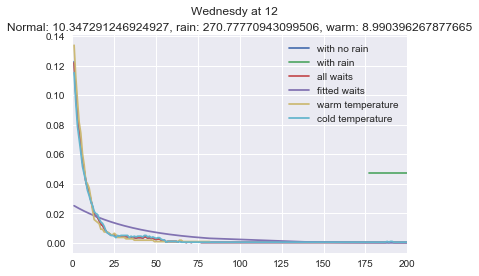

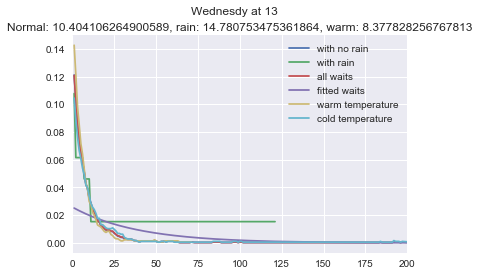

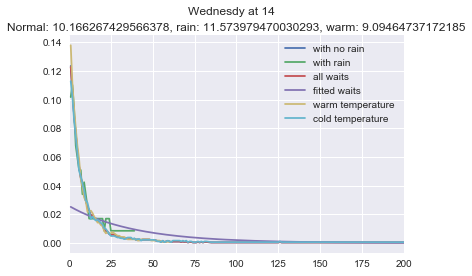

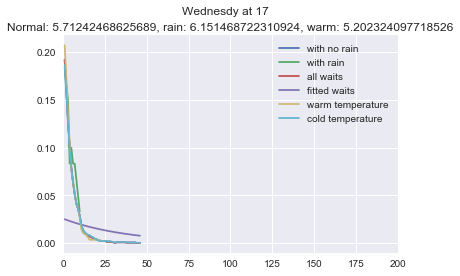

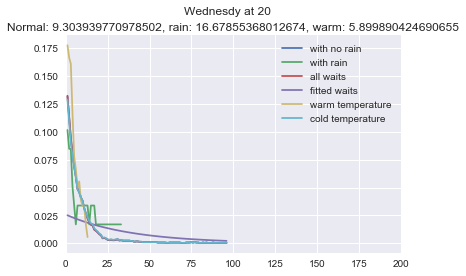

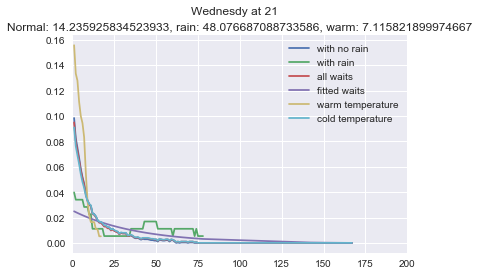

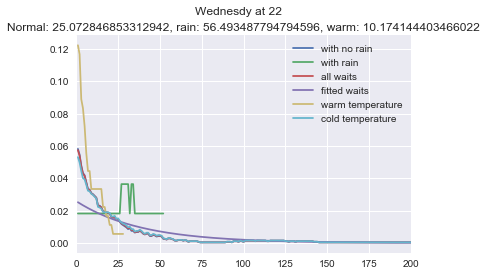

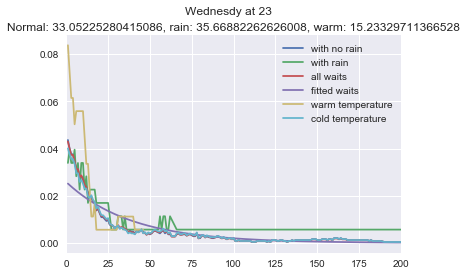

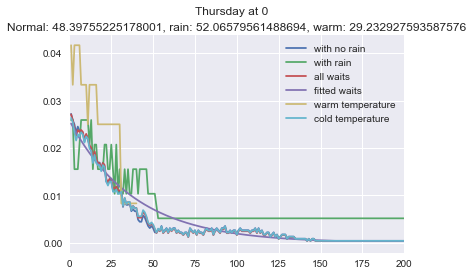

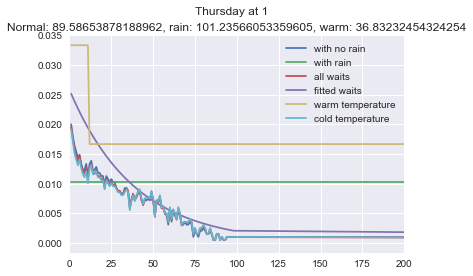

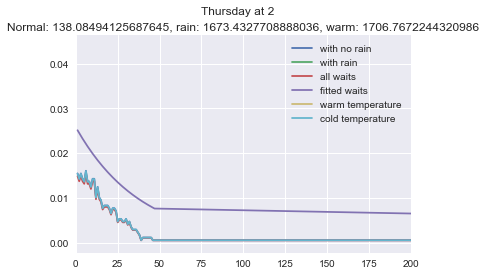

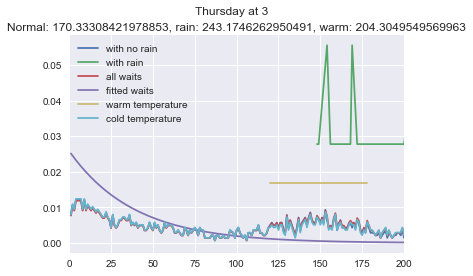

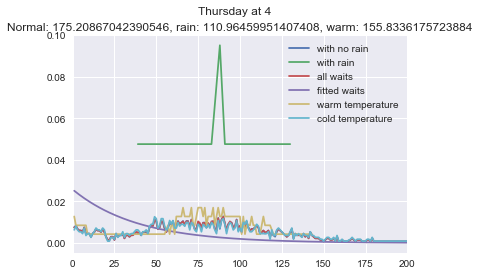

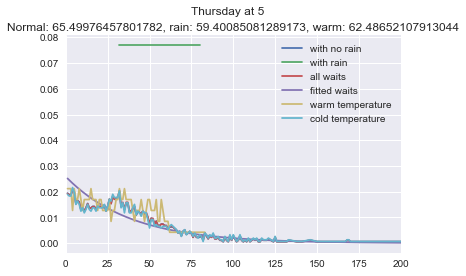

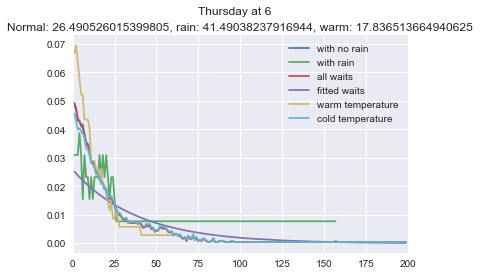

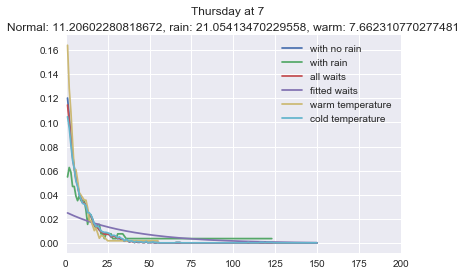

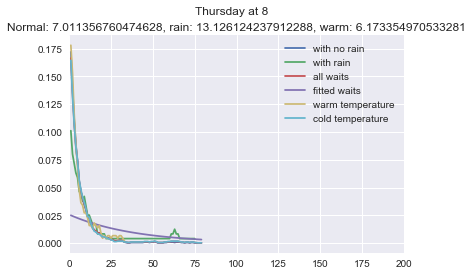

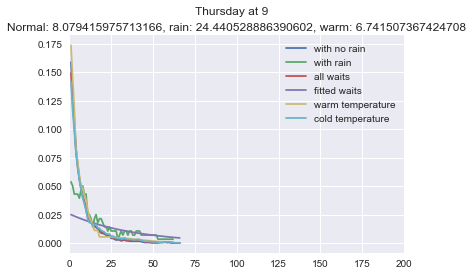

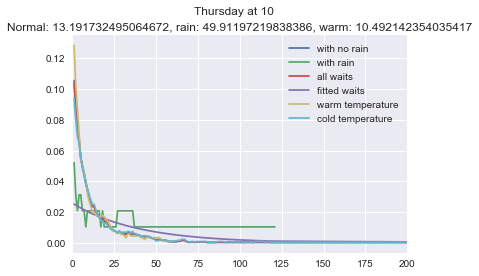

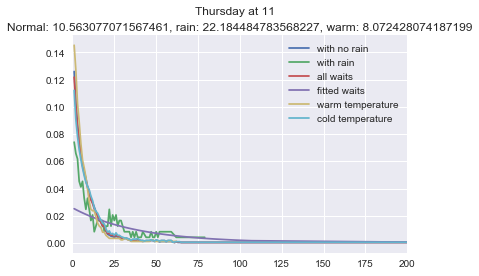

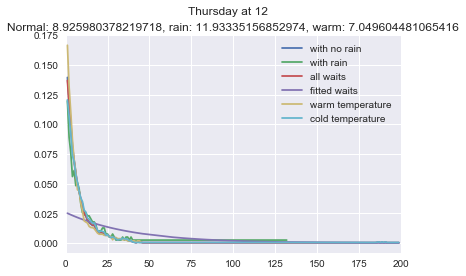

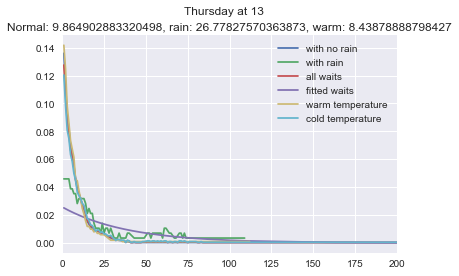

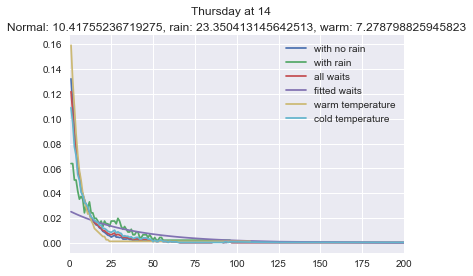

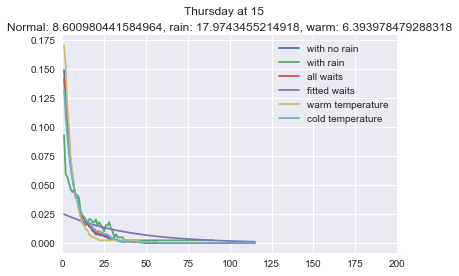

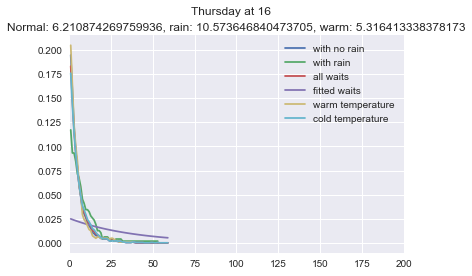

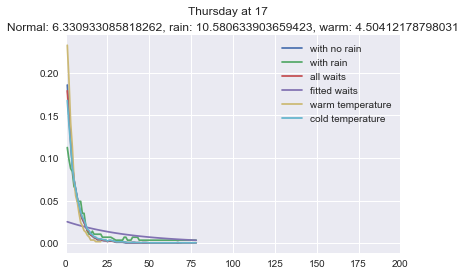

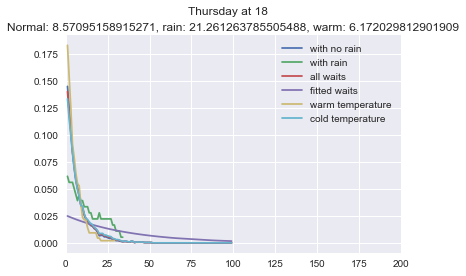

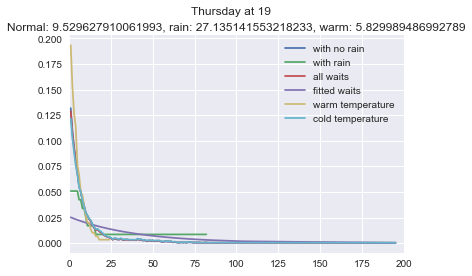

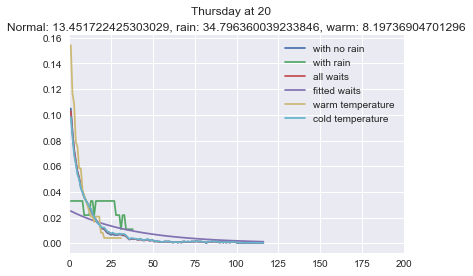

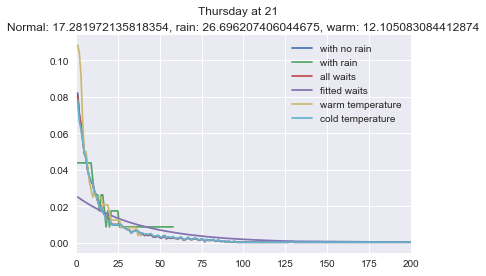

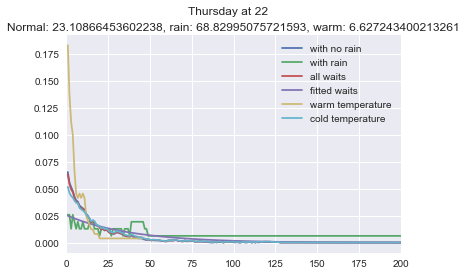

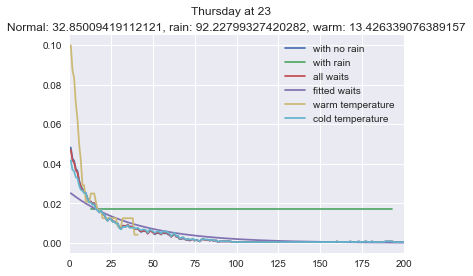

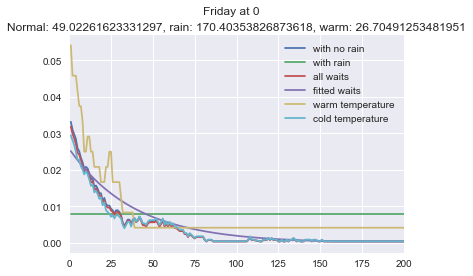

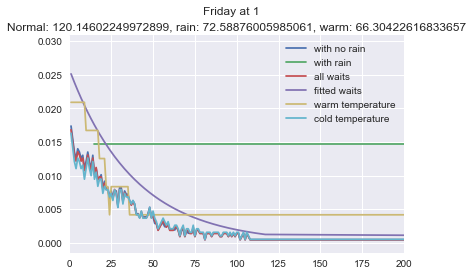

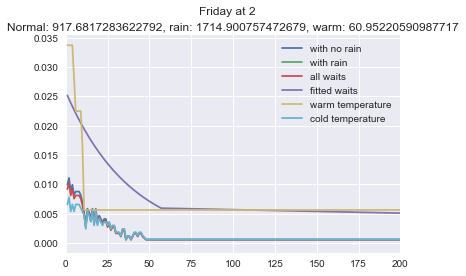

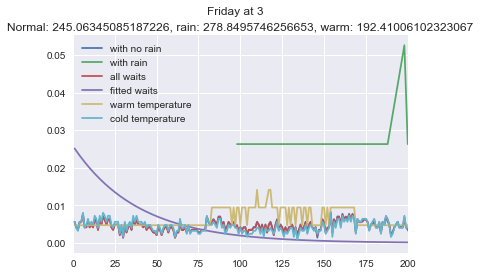

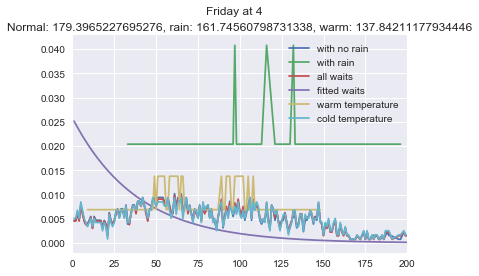

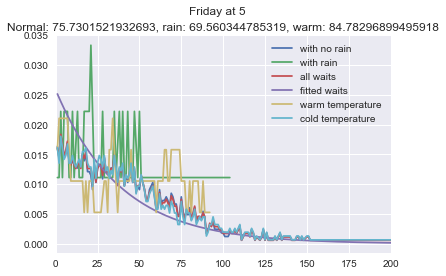

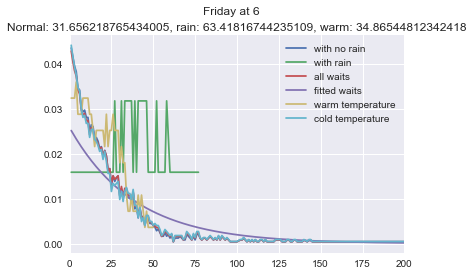

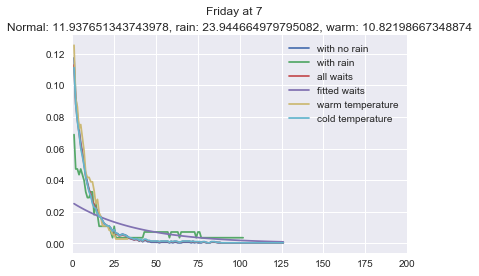

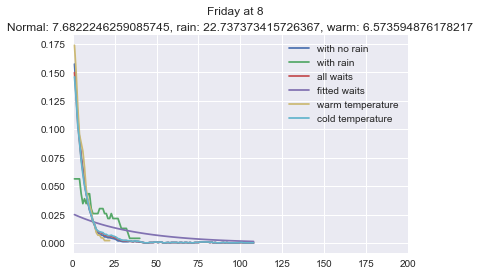

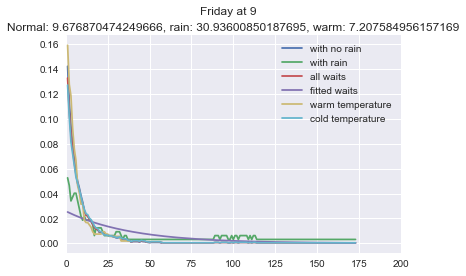

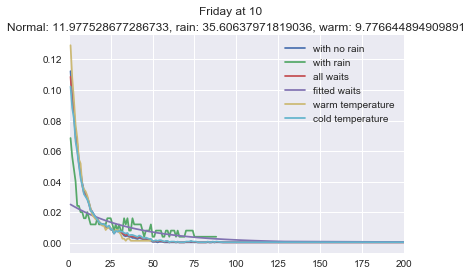

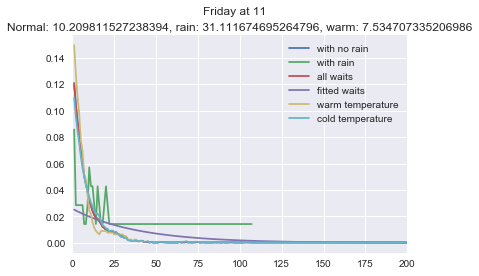

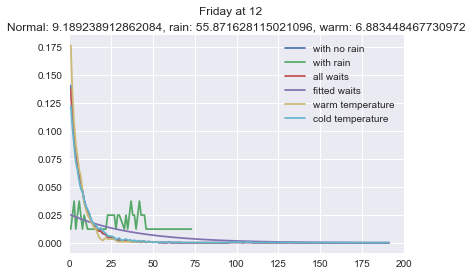

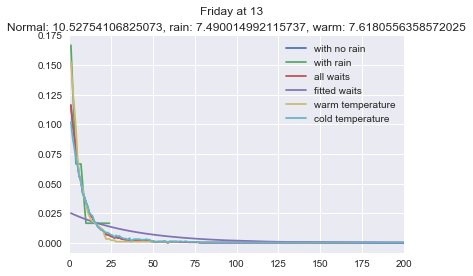

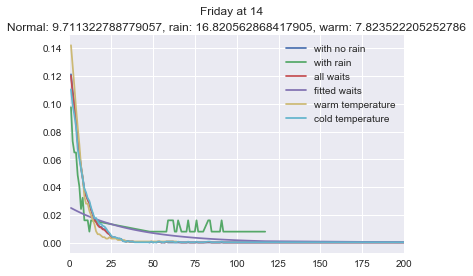

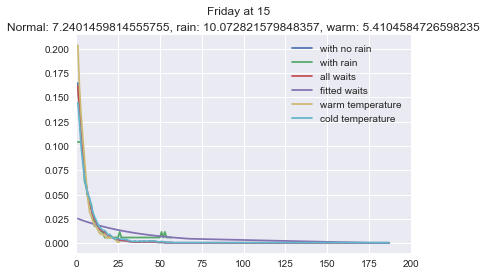

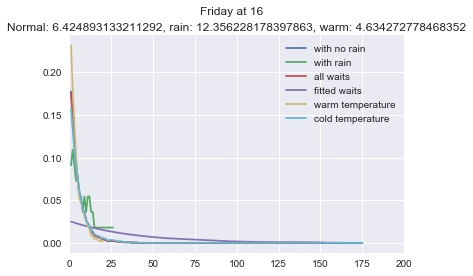

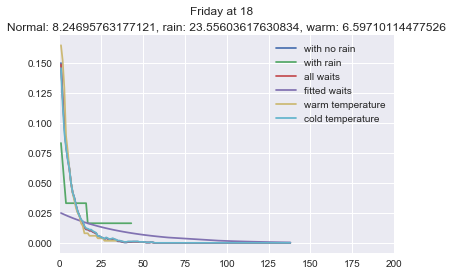

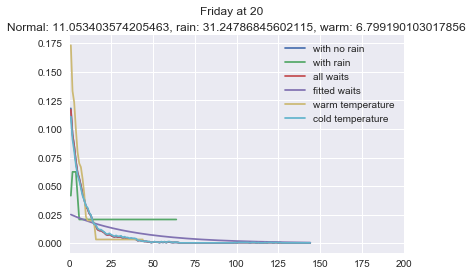

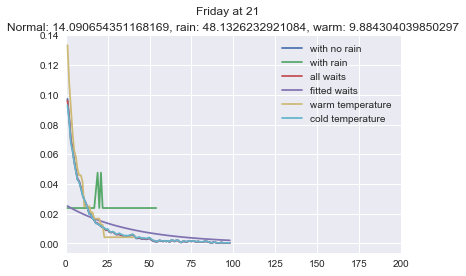

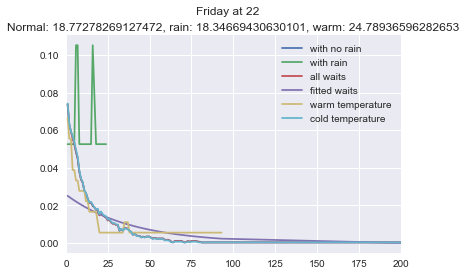

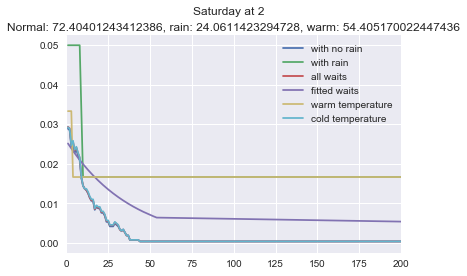

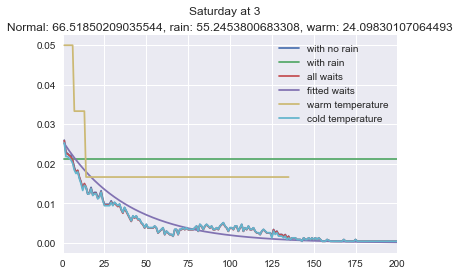

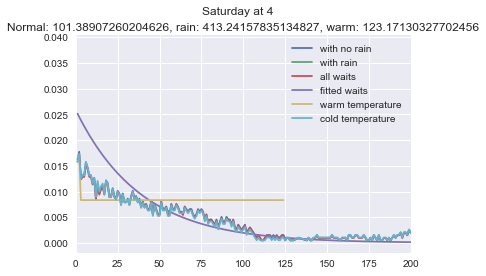

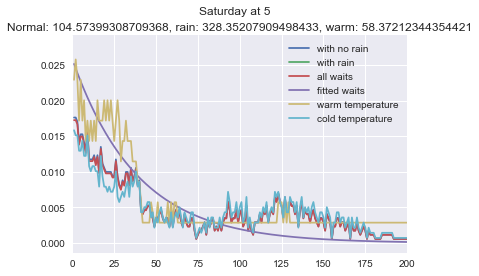

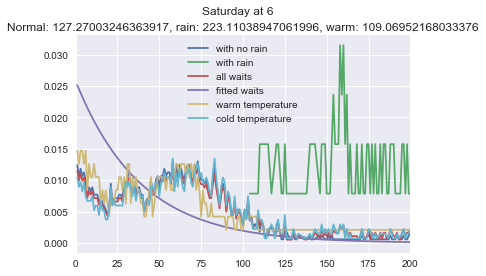

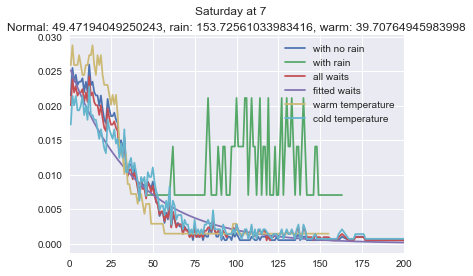

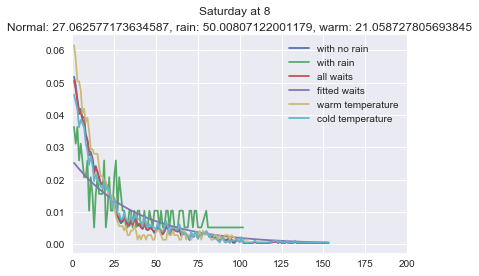

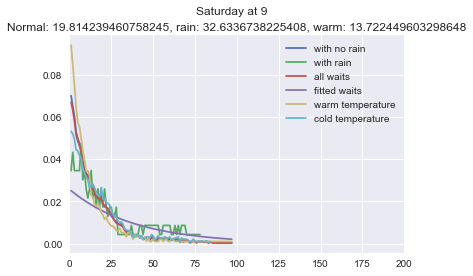

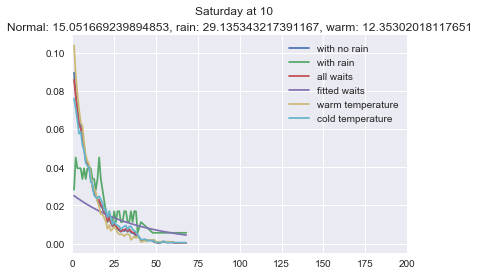

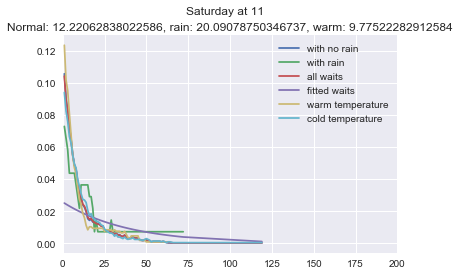

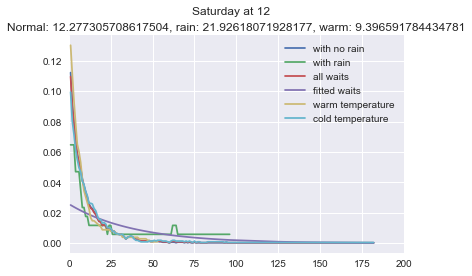

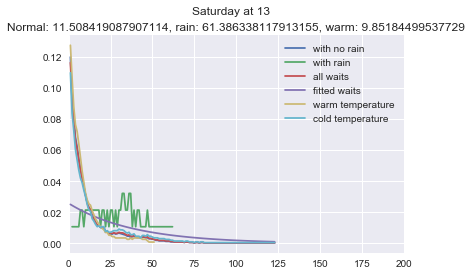

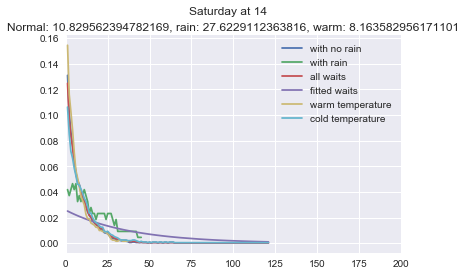

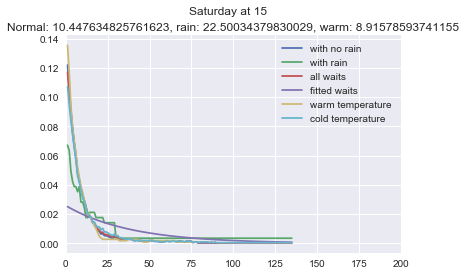

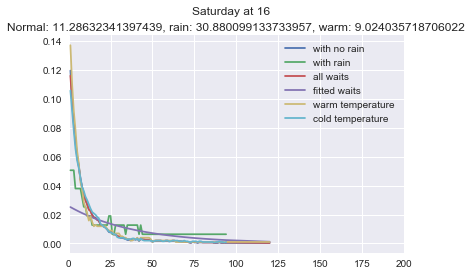

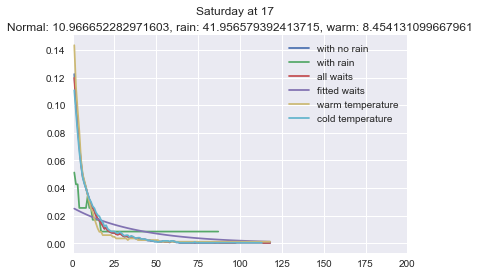

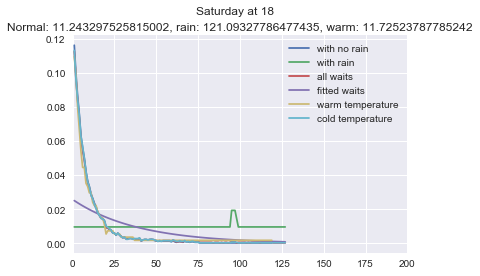

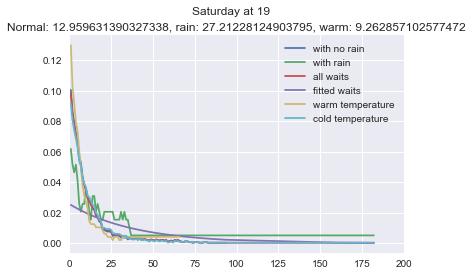

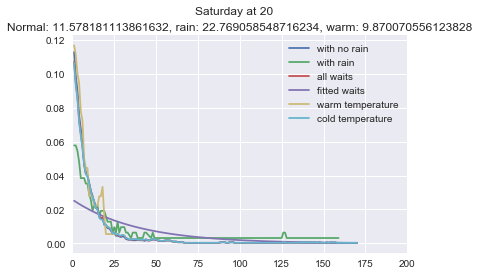

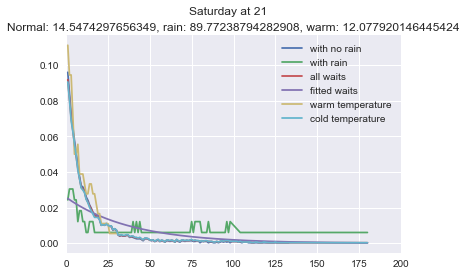

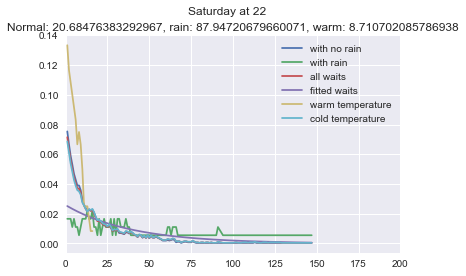

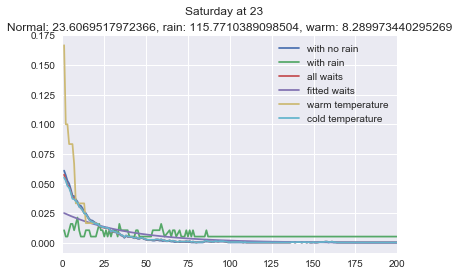

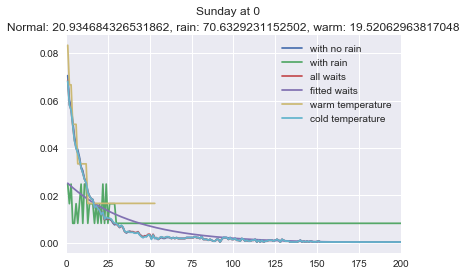

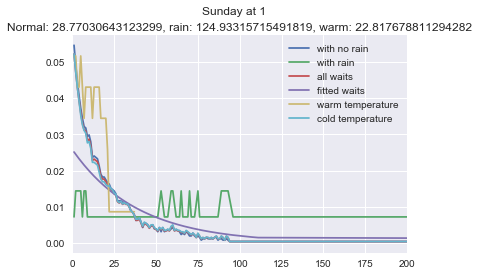

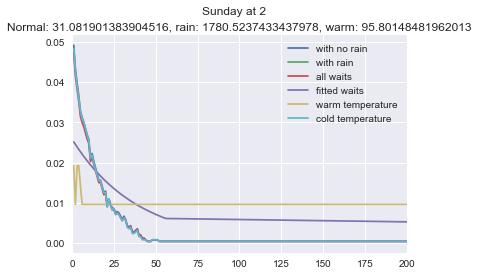

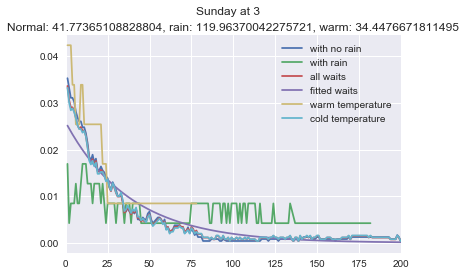

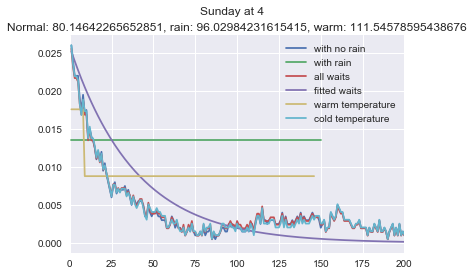

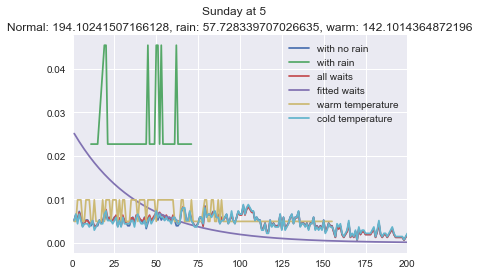

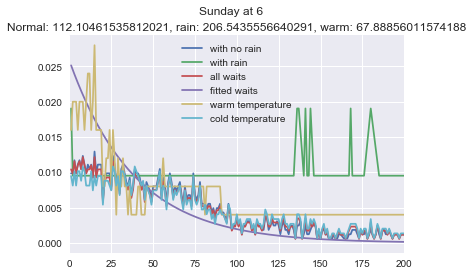

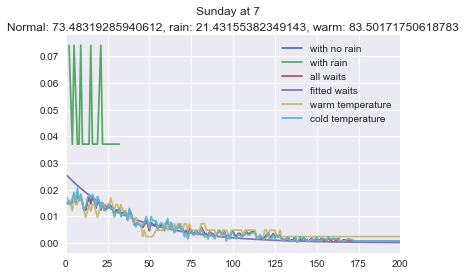

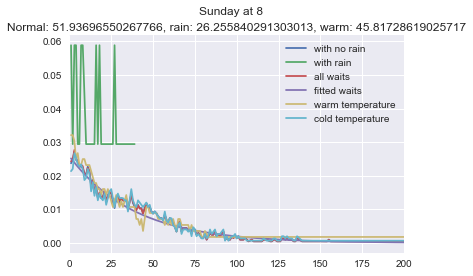

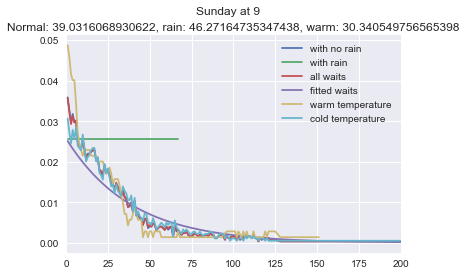

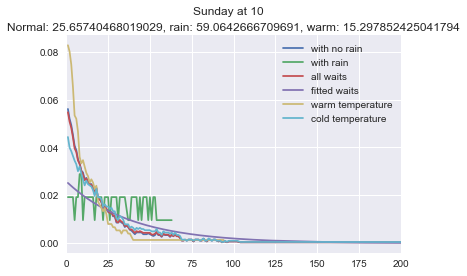

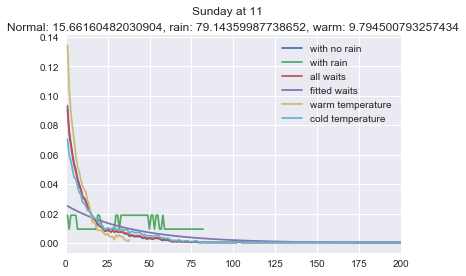

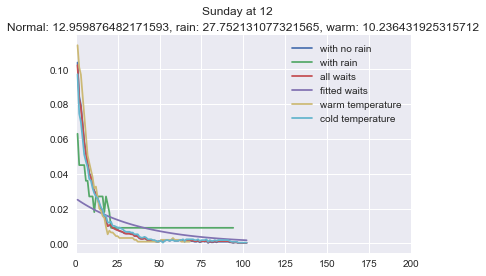

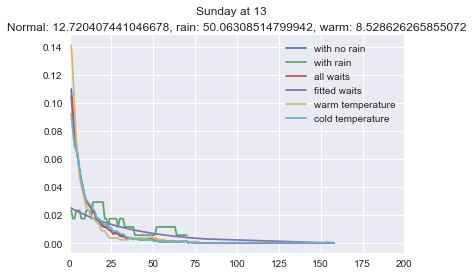

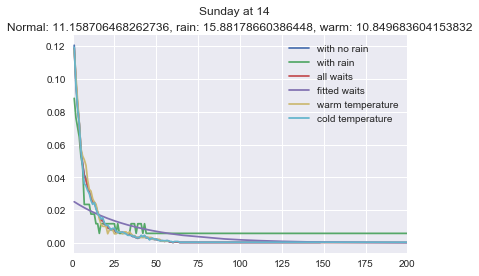

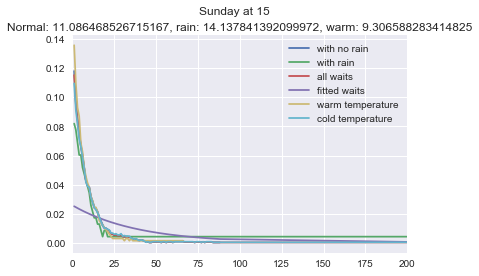

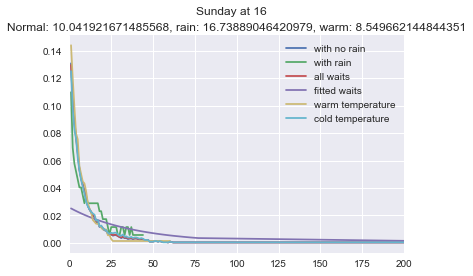

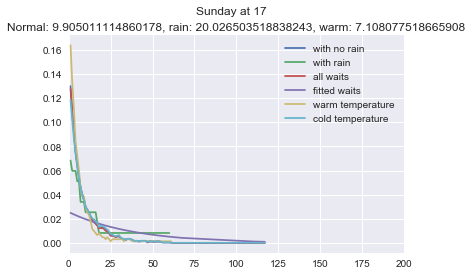

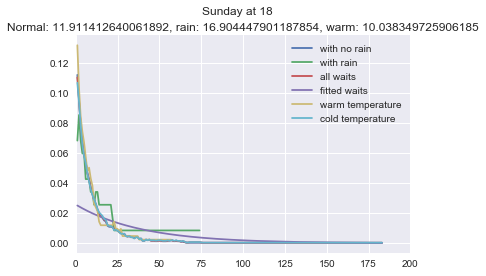

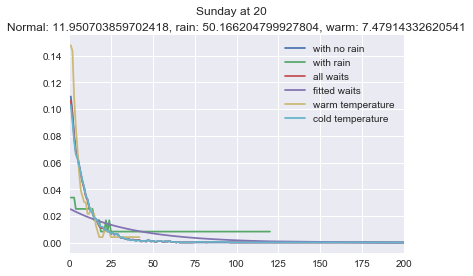

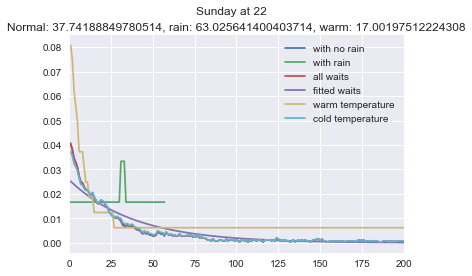

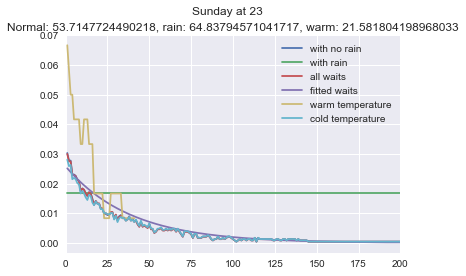

In [44]:
for estimate in estimates:
    # plot away 
    fig = plt.figure()
    plt.plot(estimate['no_rain_waits'].keys(), estimate['no_rain_waits'].values, label='with no rain')
    plt.plot(estimate['rain_waits'].keys(), estimate['rain_waits'].values, label='with rain')
    plt.suptitle(estimate['label'] + ' at ' + str(estimate['hour']))
    plt.plot(estimate['waits'].keys(), estimate['waits'].values, label='all waits')
    plt.plot(estimate['waits'].keys(), [expfunc(x, *popt) for x in estimate['waits' ].keys()], label='fitted waits')
    plt.plot(estimate['warm_waits'].keys(), estimate['warm_waits'].values ,label='warm temperature')
    plt.plot(estimate['cold_waits'].keys(), estimate['cold_waits'].values ,label='cold temperature')
    plt.title('Normal: ' + str(estimate['estimate']) + ', rain: ' + str(estimate['rain_estimate']) + ', warm: ' + str(estimate['warm_estimate']))
    plt.xlim(0, 200)
    # save figures to a files
    # fig.savefig('../data/figures/' + estimate['label'] + '_' + str(hour))
    plt.legend()
    plt.show()

## Evaluate exponential distribution model manually

In [45]:
estimate_df= pd.DataFrame.from_dict(estimates)
df_with_estimates = pd.merge(cleaned_df, estimate_df, on=['hour', 'weekday'])
df_with_estimates.describe()

operative  bikes_percent           hour        weekday  \
count   412860.0  412860.000000  412860.000000  412860.000000   
mean         1.0       0.167455      12.194967       2.959650   
std          0.0       0.175802       6.493752       2.010842   
min          1.0       0.000000       0.000000       0.000000   
25%          1.0       0.035714       7.000000       1.000000   
50%          1.0       0.107143      12.000000       3.000000   
75%          1.0       0.250000      18.000000       5.000000   
max          1.0       1.178571      23.000000       6.000000   

       wait_for_new_bike  wait_for_bike_taken  Cloud amount (1/8)  \
count      412860.000000        412860.000000       412860.000000   
mean           72.775951            70.291363            3.475486   
std           246.314455           240.576738            3.336010   
min             1.000000             1.000000            0.000000   
25%             4.000000             3.000000            0.000000   
50%             9.000000             9.000000            3.000000   
75%            26.000000            26.000000            7.000000   
max          1437.000000          1438.000000            9.000000   

       Pressure (msl) (hPa)  Relative humidity (%)  \
count         412860.000000          412860.000000   
mean            1014.210418              67.870678   
std               10.366129              19.599454   
min              972.400000              13.000000   
25%             1007.400000              53.000000   
50%             1013.700000              70.000000   
75%             1020.500000              84.000000   
max             1047.500000              99.000000   

       Precipitation intensity (mm/h)  Air temperature (degC)  \
count                   412860.000000           412860.000000   
mean                         0.082204               14.557232   
std                          0.571581                6.140642   
min                          0.000000              -17.600000   
25%                          0.000000               10.600000   
50%                          0.000000               14.800000   
75%                          0.000000               18.800000   
max                         15.700000               31.000000   

       Dew-point temperature (degC)  Horizontal visibility (m)  \
count                 412860.000000              412860.000000   
mean                       7.946729               37428.503706   
std                        5.812435               13267.441658   
min                      -20.300000                 210.000000   
25%                        3.900000               30550.000000   
50%                        8.400000               41040.000000   
75%                       12.500000               50000.000000   
max                       21.600000               50000.000000   

       Wind direction (deg)  Gust speed (m/s)  Wind speed (m/s)  \
count         412860.000000     412860.000000     412860.000000   
mean             185.114315          6.563763          4.130810   
std               97.727927          3.039298          1.841431   
min                0.000000          0.300000          0.000000   
25%               99.000000          4.400000          2.800000   
50%              200.000000          6.100000          3.900000   
75%              262.000000          8.500000          5.300000   
max              360.000000         19.700000         12.100000   

            estimate  rain_estimate  warm_estimate  
count  412860.000000  412860.000000  412860.000000  
mean       42.744911     101.374534      36.184626  
std       119.471759     281.143646     157.120073  
min         5.534860       5.822038       4.504122  
25%         9.864903      18.346694       7.115822  
50%        11.534769      30.936009       8.990396  
75%        30.736547      63.025641      19.335218  
max      1161.845594    1780.523743    1770.040377

In [47]:
def get_correct_estimate(row):
    if 'warm_estimate' not in row or 'Precipitation intensity (mm/h)' not in row:
        return row['estimate']
    # prioritize rain
    if row['Precipitation intensity (mm/h)'] > rain_limit:
        return row['rain_estimate']
    elif row['Air temperature (degC)'] > temp_limit:
        return row['warm_estimate']
    else:
        return row['estimate']    


In [ ]:
x = df_with_estimates
y = df_with_estimates['wait_for_new_bike']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print('test dataset length: ', len(y_test))
for mins in range(1, 31):
    est = x_test.apply(get_correct_estimate, axis=1)
    diff = abs(est - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(x_test)))

test dataset length:  82572
percentages of predictions within 1 mins of target: 0.05417090539165819
percentages of predictions within 2 mins of target: 0.10848713849731144
percentages of predictions within 3 mins of target: 0.1657825897398634
percentages of predictions within 4 mins of target: 0.227147216974277
percentages of predictions within 5 mins of target: 0.2915031729884222
percentages of predictions within 6 mins of target: 0.3581843724264884
percentages of predictions within 7 mins of target: 0.42096594487235384
percentages of predictions within 8 mins of target: 0.47864893668555925
percentages of predictions within 9 mins of target: 0.5276001550162283
percentages of predictions within 10 mins of target: 0.5676742721503657
percentages of predictions within 11 mins of target: 0.5975148960906845
percentages of predictions within 12 mins of target: 0.6174853461221722
percentages of predictions within 13 mins of target: 0.634646127016422
percentages of predictions within 14 mins o

## We also tried to fit weather estimates to linear regression, to avoid building different modles for different weathers by hand but the results weren't very good

### Add info for linear regression

In [ ]:
df_with_estimates['is_raining'] = df_with_estimates['Precipitation intensity (mm/h)'].apply(lambda x: x >= rain_limit)
df_with_estimates['is_warm'] = df_with_estimates['Air temperature (degC)'].apply(lambda x: x >= temp_limit)

In [ ]:
def get_correct_rain_estimate(row):
    if 'warm_estimate' not in row or 'Precipitation intensity (mm/h)' not in row:
        return row['estimate']
    # prioritize rain
    if row['Precipitation intensity (mm/h)'] > rain_limit:
        return row['rain_estimate']
    else:
        return row['estimate']

def get_correct_temp_estimate(row):
    if 'warm_estimate' not in row or 'Precipitation intensity (mm/h)' not in row:
        return row['estimate']
    if row['Air temperature (degC)'] > temp_limit:
        return row['warm_estimate']
    else:
        return row['estimate']    

In [ ]:
x = df_with_estimates[['estimate', 'is_raining']]
print('predicting based on', ', '.join(x.columns.values))
y = df_with_estimates['rain_estimate']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train.apply(get_correct_rain_estimate, axis=1).values.reshape(-1, 1), y_train)
print('score:', model.score(x_test.apply(get_correct_rain_estimate, axis=1).values.reshape(-1, 1), y_test))

In [ ]:
x = df_with_estimates[['estimate', 'is_warm']]
print('predicting based on', ', '.join(x.columns.values))
y = df_with_estimates['warm_estimate']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train.apply(get_correct_rain_estimate, axis=1).values.reshape(-1, 1), y_train)
print('score:', model.score(x_test.apply(get_correct_temp_estimate, axis=1).values.reshape(-1, 1), y_test))

# So in the end we decided to calculate an estimate for rainy and warm weather separately